In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Integer, Real
from skopt.utils import use_named_args

from simulation_utils.calibration import compute_cosine_similarity_pd, _sample_pairs
from simulation_utils.datasets import DataStats, ml_1m
from simulation_utils.preference import LatentDirichletAllocationCSR, IndianBuffetProcessCSR
from simulation_utils.observation import PopularityObservationCSR, UniformObservationCSR
from simulation_utils.observation import TruncParetoProfile
# %matplotlib inline

In [2]:
def ibp_unif_pareto(nusers=943, alpha=825.104806974929, c=0.8769365301765374, sigma=0,
                    m=20.00000045, obs_alpha=0.510528, upper=737,
                    fname='lda_pop.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = IndianBuffetProcessCSR(nusers, alpha, c, sigma).generate()
    trunc_pareto = TruncParetoProfile(m, obs_alpha, upper)
    obs = UniformObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [3]:
def ibp_pop_pareto(nusers=943, alpha=825.104806974929, c=0.8769365301765374, sigma=0,
                   m=20.00000045, obs_alpha=0.510528, upper=737,
                   fname='lda_pop.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = IndianBuffetProcessCSR(nusers, alpha, c, sigma).generate()
    trunc_pareto = TruncParetoProfile(m, obs_alpha, upper)
    obs = PopularityObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [4]:
def lda_pop_pareto(nusers=943, nitems=1682, k=10, lam=434.8731099953002, a=20.0, b=1.01, 
                   m=20.00000045, alpha=0.510528, upper=737, 
                   fname='lda_pop.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = LatentDirichletAllocationCSR(nusers, nitems, k, lam, a, b).generate()
    trunc_pareto = TruncParetoProfile(m, alpha, upper)
    obs = PopularityObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [5]:
def lda_unif_pareto(nusers=943, nitems=1682, k=10, lam=434.8731099953002, a=20.0, b=1.01, 
                    m=20.00000045, alpha=0.510528, upper=737, 
                    fname='lda_unif.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = LatentDirichletAllocationCSR(nusers, nitems, k, lam, a, b).generate()
    trunc_pareto = TruncParetoProfile(m, alpha, upper)
    obs = UniformObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [6]:
def compute_density(data):
    nusers = len(data['user'].unique())
    nitems = len(data['item'].unique())
    npairs = len(data)
    density = npairs / nitems / nusers
    return nusers, nitems, npairs, density

In [7]:
def compute_data_stats(data):
    pairs = data.loc[:, ['user', 'item']]
    user_activity = pairs.groupby('user', as_index=False).count().rename(columns={'item': 'count'})
    item_popularity = pairs.groupby('item', as_index=False).count().rename(columns={'user': 'count'})
    return user_activity, item_popularity

In [8]:
def summarize_dataset(name, data_func, *args, **kwargs):
    if isinstance(data_func, pd.DataFrame):
        dataset = data_func
    else:
        dataset = data_func(*args, **kwargs)
    colname = dataset.columns
    if not {'user', 'item'}.issubset(colname):
        dataset.rename(columns={colname[0]: 'user',
                                colname[1]: 'item'},
                       inplace=True)
    dataset = dataset[['user', 'item']]
    data_meta = compute_density(dataset)
    data_meta_stats = tuple([name, *data_meta])
    
    user_activity, item_popularity = compute_data_stats(dataset)
    user_activity['dataset'] = name
#     user_activity.drop('user', axis=1, inplace=True)
    item_popularity['dataset'] = name
#     item_popularity.drop('item', axis=1, inplace=True)
    item_popularity['rank'] = item_popularity['count'].rank(method='min', ascending=False)

    user_activity_stats = user_activity['count'].rename(name).describe()
    item_popularity_stats = item_popularity['count'].rename(name).describe()
    return data_meta_stats, user_activity_stats, item_popularity_stats, user_activity, item_popularity

In [9]:
def make_grids(figsize=(14, 6), ngrids_left=3, ngrids_right=1):
    fig = plt.figure(figsize=figsize)
    gs_left = GridSpec(ngrids_left, 1)
    gs_left.update(left=0.05, right=0.48, wspace=0.05, hspace=0.05)
    for i in range(ngrids_left):
        ax = plt.subplot(gs_left[i, 0])
    for ax in fig.axes[:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labelbottom=False, bottom=False)
    for ax in fig.axes[1:]:
        ax.spines['top'].set_visible(False)

    gs_right = GridSpec(ngrids_right, 1)
    gs_right.update(left=0.55, right=0.98, wspace=0.05, hspace=0.05)
    for i in range(ngrids_right):
        ax = plt.subplot(gs_right[i, 0])
    for ax in fig.axes[ngrids_left:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labelbottom=False, bottom=False)
    for ax in fig.axes[ngrids_left+1:]:
        ax.spines['top'].set_visible(False)
    return fig, fig.axes

In [10]:
def make_nested_grids(figsize=(14, 20), ylim_left=(None, None, None, None)):
    fig = plt.figure(figsize=figsize)
    gs_outer = GridSpec(4, 2, figure=fig, wspace=0.3, hspace=0.4)
    for i in range(8):
        if i % 2 == 0:
            ylim = ylim_left[i // 2]
            ngrids = len(ylim) if ylim else 1
            gs_inner = gs_outer[i].subgridspec(ngrids, 1)
            for j in range(ngrids):
                ax = fig.add_subplot(gs_inner[j, :])
                if j < ngrids - 1:
                    ax.spines['bottom'].set_visible(False)
                    ax.tick_params(labelbottom=False, bottom=False)
                if j > 0:
                    ax.spines['top'].set_visible(False)
        else:
            gs_inner = gs_outer[i].subgridspec(1, 1)
            ax = fig.add_subplot(gs_inner[0, :])
    return fig

In [11]:
def plot_stats(base, simulated, base_arg=(), args=(), ylim_left=None, ylim_left2=None, ylim_left4=None, mrated=1):
    """
    Args:
        base (`tuple` of str, function): name and data function
        simulated (`tuple` of `str`, `function`): name and simulated data function
        base_arg: position args for data function
        args: position args for simulated data function
    """
    ml_name, data_func, lda_name, simulated_lda_func = *base, *simulated
    data = data_func(*base_arg)
    data['rating'] = 1
    if callable(simulated_lda_func):
        simulated_lda = simulated_lda_func(*args)
    else:
        simulated_lda = simulated_lda_func
    simulated_lda['rating'] = 1
    ml_meta, ml_uastats, ml_ipstats, ml_ua, ml_ip = summarize_dataset(ml_name, data)
    lda_meta, lda_uastats, lda_ipstats, lda_ua, lda_ip = summarize_dataset(lda_name, simulated_lda)
    # show data stats
    df = pd.DataFrame.from_records([ml_meta, lda_meta],
                                   columns=['dataset', 'nusers', 'nitems', 'npairs', 'density'])
    print('dataset stats')
    print(df)
    df = pd.concat([ml_ipstats, lda_ipstats], axis=1)
    print('item popularity stats')
    print(df)
    df = pd.concat([ml_uastats, lda_uastats], axis=1)
    print('user profile stats')
    print(df)
    # minimum n ratings
    ml_upairs = ml_ua[ml_ua['count'] >= mrated]['user'].values
    ml_ipairs = ml_ip[ml_ip['count'] >= mrated]['item'].values
    lda_upairs = lda_ua[lda_ua['count'] >= mrated]['user'].values
    lda_ipairs = lda_ip[lda_ip['count'] >= mrated]['item'].values
    data_ucosine = data[data['user'].isin(ml_upairs)]
    data_icosine = data[data['item'].isin(ml_ipairs)]
    simulated_lda_ucosine = simulated_lda[simulated_lda['user'].isin(lda_upairs)]
    simulated_lda_icosine = simulated_lda[simulated_lda['item'].isin(lda_ipairs)]

    ml_dcorr = compute_cosine_similarity_pd(data_icosine, _sample_pairs, 'item', 'user')
    lda_dcorr = compute_cosine_similarity_pd(simulated_lda_icosine, _sample_pairs, 'item', 'user')
    data2plot = pd.concat([pd.DataFrame({'dataset': ml_name, 'corr': ml_dcorr}),
                           pd.DataFrame({'dataset': lda_name, 'corr': lda_dcorr})],
                          ignore_index=True)
    hue_order = [ml_name, lda_name]
    colors = dict(zip(hue_order, ['#1f77b4', '#ff7f0e']))
    grid_id = 0
    with sns.plotting_context('talk', 1):
        fig = make_nested_grids(ylim_left=(ylim_left, ylim_left2, None, ylim_left4))
        # plot distributions
        axes = fig.axes[grid_id:grid_id + len(ylim_left)] if ylim_left else fig.axes[grid_id:grid_id + 1]
        for i, ax in enumerate(axes):
            for key, group in data2plot.groupby('dataset'):
                sns.distplot(group['corr'], ax=ax, label=key, color=colors[key], axlabel=False)
                if ylim_left is not None:
                    ax.set_ylim(*ylim_left[i])
            grid_id += 1
#         fig.text(0.07, 0.82, 'Density', ha='center', va='center', rotation='vertical')
        nsubgrids = len(axes)
        axes[nsubgrids // 2].set_ylabel('Density')
        if (nsubgrids % 2) == 0:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 1)
        else:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 0.5)
        axes[-1].set_xlabel('I-I Sim')
        axes[0].legend()
        ax = sns.boxplot(x='dataset', y='corr', hue='dataset', hue_order=hue_order, data=data2plot, ax=fig.axes[grid_id], dodge=False)
        ax.legend(loc='upper right')
        ax.set_ylabel('I-I Sim')
        ax.set_xlabel('')
#         fig.suptitle('item item similarity')
        grid_id += 1

        # second plot
        ml_dcorr = compute_cosine_similarity_pd(data_ucosine, _sample_pairs)
        lda_dcorr = compute_cosine_similarity_pd(simulated_lda_ucosine, _sample_pairs)
        data2plot = pd.concat([pd.DataFrame({'dataset': ml_name, 'corr': ml_dcorr}),
                               pd.DataFrame({'dataset': lda_name, 'corr': lda_dcorr})],
                              ignore_index=True)
        axes = fig.axes[grid_id:grid_id + len(ylim_left2)] if ylim_left2 else fig.axes[grid_id:grid_id + 1]
        for i, ax in enumerate(axes):
            grid_id += 1
            for key, group in data2plot.groupby('dataset'):
                sns.distplot(group['corr'], ax=ax, label=key, color=colors[key], axlabel=False)
                if ylim_left2 is not None:
                    ax.set_ylim(*ylim_left2[i])
        nsubgrids = len(axes)
        if (nsubgrids % 2) == 0:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 1)
        else:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 0.5)
        axes[nsubgrids // 2].set_ylabel('Density')
        axes[-1].set_xlabel('U-U Sim')
        axes[0].legend()
        ax = sns.boxplot(x='dataset', y='corr', hue='dataset', hue_order=hue_order, data=data2plot, ax=fig.axes[grid_id], dodge=False)
        ax.legend(loc='upper right')
        ax.set_ylabel('U-U Sim')
        ax.set_xlabel('')
#         fig.suptitle('user user similarity')
        grid_id += 1
    
        # third plot
        ax1, ax2 = fig.axes[grid_id:grid_id + 2]
        data2plot = pd.concat([ml_ip, lda_ip], ignore_index=True)
        data2plot = data2plot.rename(columns={'dataset': 'Data'})
        sns.scatterplot('rank', 'count', hue='Data', hue_order=hue_order, ax=ax1, data=data2plot)
        ax1.set(xscale="log", yscale="log")
        ax1.set_xlabel('Popularity Rank')
        ax1.set_ylabel('Number of Items')
#         ax1.set_title('item popularity curve')
        grid_id += 1
        data2plot = data2plot.groupby(['Data', 'count']).size().reset_index().rename(columns={'count': 'popularity', 0: 'count'})
        sns.scatterplot('popularity', 'count', hue='Data', hue_order=hue_order, ax=ax2, data=data2plot)
        ax2.set(xscale="log", yscale="log")
        ax2.set_xlabel('Item Popularity')
        ax2.set_ylabel('Number of Items')
#         ax2.set_title('popularity distribution')
        grid_id += 1

        # fourth plot
        data2plot = pd.concat([ml_ua, lda_ua], ignore_index=True)
        data2plot = data2plot.rename(columns={'dataset': 'Data'})
        axes = fig.axes[grid_id:grid_id + len(ylim_left4)] if ylim_left4 else fig.axes[grid_id:grid_id + 1]
        for i, ax in enumerate(axes):
            grid_id += 1
            for key, group in data2plot.groupby('Data'):
                sns.distplot(group['count'], ax=ax, label=key, color=colors[key], axlabel=False, hist_kws={'alpha':0.5}, kde=False)
                if ylim_left4 is not None:
                    ax.set_ylim(*ylim_left4[i])
        axes[0].legend()
        axes[0].set_title('Histogram')
        axes[-1].set_xlabel('User Activity')
        nsubgrids = len(axes)
        axes[nsubgrids // 2].set_ylabel('Number of Users')
        if (nsubgrids % 2) == 0:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 1)
        else:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 0.5)
#         axes[-1].set_ylabel('Number of Users')
        data2plot = data2plot.groupby(['Data', 'count']).size().reset_index().rename(columns={'count': 'User Activity', 0: 'Number of Users'})
        ax = sns.scatterplot('User Activity', 'Number of Users', hue='Data', hue_order=hue_order, ax=fig.axes[grid_id], data=data2plot)
        ax.set_title('Scatter Plot')
        plt.show()

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


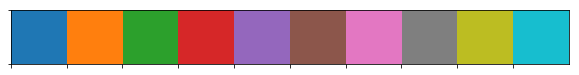

In [12]:
current_palette = sns.color_palette()
sns.palplot(current_palette)
print(current_palette.as_hex())

Check that parameters in `gp_minimize` results for each single statistic are equal to parameters in `params*` files.

In [13]:
data = ['ml_1m']
models = ['lda_unif', 'lda_pop', 'ibp_unif', 'ibp_pop', 'unif_unif', 'unif_pop']
metrics = ['ucorr', 'icorr', 'item-pop', 'user-act']
for d in data:
    for m in models:
        for metric in metrics:
            res_gp = skopt.load(f'build/gp_minimize_{m}_csr-{d}-{metric}.pkl')
            print(d, m, metric, res_gp.fun)
            try:
                with open(f'build/params_{m}_csr-{d}-{metric}.pkl', 'rb') as f:
                    params = pickle.load(f)
                if 'lda' in m or 'unif_unif' in m or 'unif_pop' in m:
                    assert params == [6040, 3706, *res_gp.x] 
                elif 'ibp' in m:
                    assert params == [6040, *res_gp.x]
            except:
                if 'lda' in m or 'unif_unif' in m or 'unif_pop' in m:
                    params = [6040, 3706, *res_gp.x]
                elif 'ibp' in m:
                    params = [6040, *res_gp.x]
                print('rewrite params for', d, m, metric, params)
                with open(f'build/params_{m}_csr-{d}-{metric}.pkl', 'wb') as f:
                    pickle.dump(params, f)

ml_1m lda_unif ucorr 0.039165975389915404
ml_1m lda_unif icorr 0.01219620474531264
ml_1m lda_unif item-pop 0.40835697173809504
ml_1m lda_unif user-act 0.28116081820943595
ml_1m lda_pop ucorr 0.018393478110145037
ml_1m lda_pop icorr 0.0022155974149804603
ml_1m lda_pop item-pop 0.4016609188511891
ml_1m lda_pop user-act 0.22130106386986026
ml_1m ibp_unif ucorr 0.06009520051895485
ml_1m ibp_unif icorr 0.11534920303693451
ml_1m ibp_unif item-pop 0.5226902837115196
ml_1m ibp_unif user-act 0.24486976031753746
ml_1m ibp_pop ucorr 0.06492676332403066
ml_1m ibp_pop icorr 0.08944698170461593
ml_1m ibp_pop item-pop 0.5622671106909608
ml_1m ibp_pop user-act 0.23709582878737792
ml_1m unif_unif ucorr 0.1894212706465473
ml_1m unif_unif icorr 1.6468318203567824
ml_1m unif_unif item-pop 3.134526970789243
ml_1m unif_unif user-act 0.24474026661079307
ml_1m unif_pop ucorr 0.19106765649376659
ml_1m unif_pop icorr 1.5841457594536685
ml_1m unif_pop item-pop 2.9308806243579415
ml_1m unif_pop user-act 0.2379526

Check that parameters in `skopt*` results for avg. relative loss are equal to parameters in `params*` files.

ml_1m lda_unif 17.24649410803431


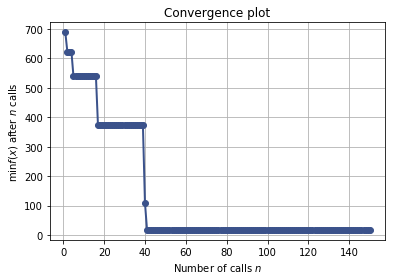

ml_1m lda_pop 10.738404717050713


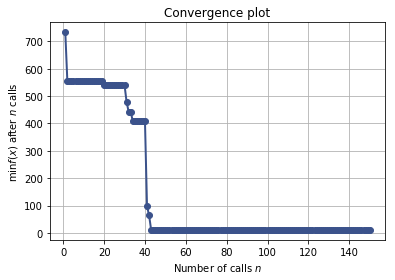

ml_1m ibp_unif 22.660777239542437


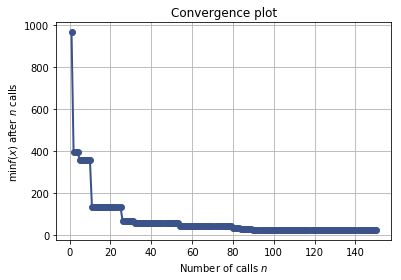

ml_1m ibp_pop 24.48046635405455


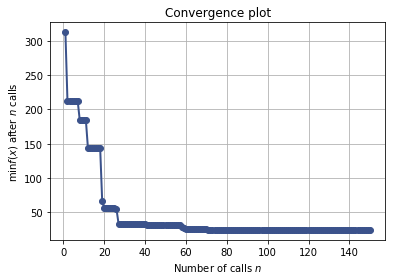

ml_1m unif_unif 465.82189224465196


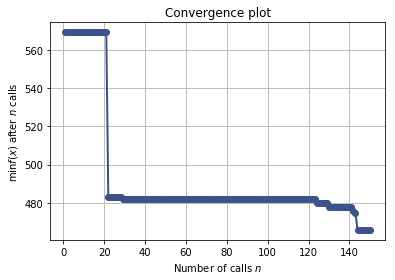

ml_1m unif_pop 262.06515583558394


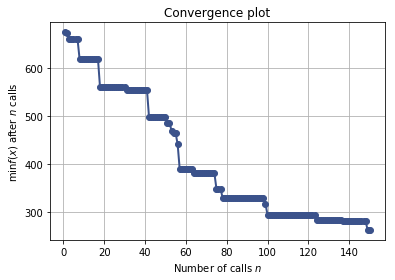

In [14]:
data = ['ml_1m']
models = ['lda_unif', 'lda_pop', 'ibp_unif', 'ibp_pop', 'unif_unif', 'unif_pop']
for d in data:
    for m in models:   
        res_gp = skopt.load(f'build/skopt_{m}-{d}.pkl')
        print(d, m, res_gp.fun)
        with open(f'build/params_{m}-{d}.pkl', 'rb') as f:
            params = pickle.load(f)
        if 'lda' in m or 'unif_unif' in m or 'unif_pop' in m:
            assert params == [6040, 3706, *res_gp.x] 
        elif 'ibp' in m:
            assert params == [6040, *res_gp.x]
        plot_convergence(res_gp)
        plt.show()

Print explored parameter bound for skopt

In [15]:
def search_space(file):
    res_gp = skopt.load(file)
    if 'lda' in file:
        labels = ['k', 'lambda', 'a', 'b', 'm', 'alpha', 'upper']
    else:
        labels = ['alpha', 'c', 'sigma', 'm', 'alpha', 'upper']
    print(*zip(labels, zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))), res_gp.fun)

## ML 1M

### lda unif on user user

In [16]:
search_space('build/gp_minimize_lda_unif_csr-ml_1m-ucorr-1-2019-04-07-21-27-34.pkl')
search_space('build/gp_minimize_lda_unif_csr-ml_1m-ucorr.pkl')

('k', (10.0, 100.0)) ('lambda', (5.000000000000001, 2000.0)) ('a', (0.01, 1.0)) ('b', (0.01, 1.0)) ('m', (16.0, 24.0)) ('alpha', (0.1, 1000.0)) ('upper', (1851.2, 2776.7999999999997)) 0.003705048974499582
('k', (5.0, 200.0)) ('lambda', (5.000000000000001, 2000.0)) ('a', (0.01, 1.0)) ('b', (0.01, 1.0)) ('m', (16.0, 24.0)) ('alpha', (0.1, 20.0)) ('upper', (1851.2, 2776.7999999999997)) 0.039165975389915404


[5, 609.3715614039834, 1.0, 0.06483426788909076, 19.73724949370142, 0.1, 1851.2] 0.039165975389915404
simulated data is used


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  LDA-Unif    6040    3372  1233116  0.060545
item popularity stats
              ML1M     LDA-Unif
count  3706.000000  3372.000000
mean    269.889099   365.692764
std     384.047838   460.450420
min       1.000000     1.000000
25%      33.000000    28.000000
50%     123.500000   166.000000
75%     350.000000   531.250000
max    3428.000000  2608.000000
user profile stats
              ML1M     LDA-Unif
count  6040.000000  6040.000000
mean    165.597517   204.158278
std     192.747029   162.565720
min      20.000000    19.000000
25%      44.000000    50.000000
50%      96.000000   147.000000
75%     208.000000   395.000000
max    2314.000000   495.000000


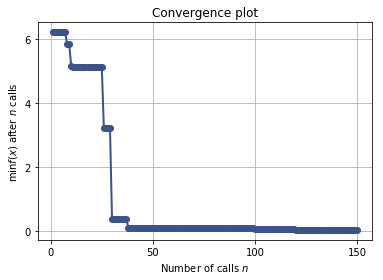

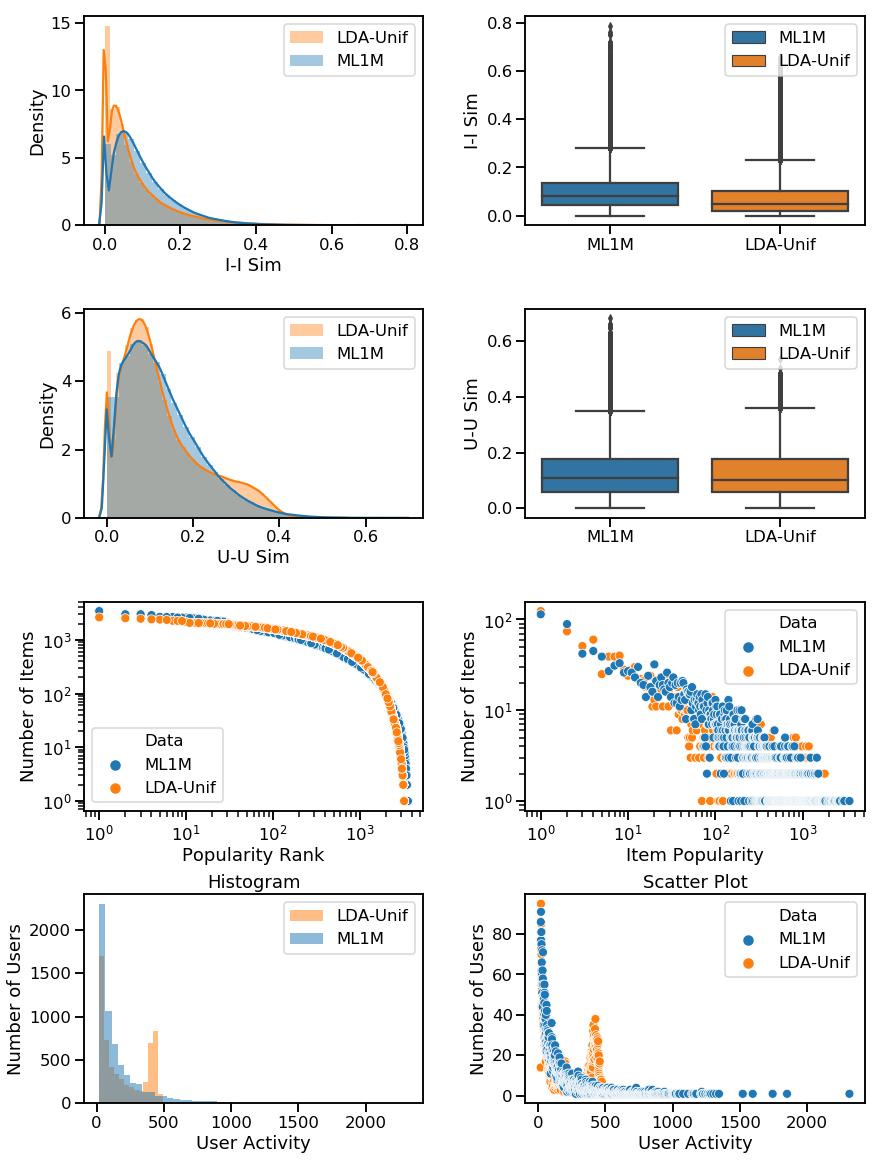

In [17]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-ml_1m-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-ml_1m-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif_csr-ml_1m-ucorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('LDA-Unif', simulated_data), mrated=5)

### lda unif on item item

[5, 744.4869939245305, 0.8914409052562254, 0.13353526625585724, 18.004427022930983, 0.1, 2451.152633385974] 0.01219620474531264
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  LDA-Unif    6040    3652  1481711  0.067173
item popularity stats
              ML1M     LDA-Unif
count  3706.000000  3652.000000
mean    269.889099   405.725904
std     384.047838   392.257641
min       1.000000     1.000000
25%      33.000000    92.000000
50%     123.500000   280.500000
75%     350.000000   606.000000
max    3428.000000  2252.000000
user profile stats
              ML1M     LDA-Unif
count  6040.000000  6040.000000
mean    165.597517   245.316391
std     192.747029   215.736938
min      20.000000    18.000000
25%      44.000000    49.000000
50%      96.000000   150.000000
75%     208.000000   509.000000
max    2314.000000   636.000000


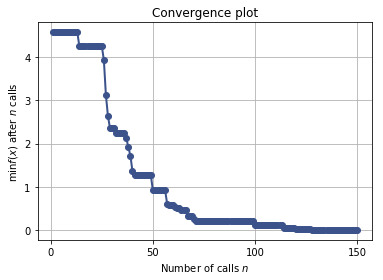

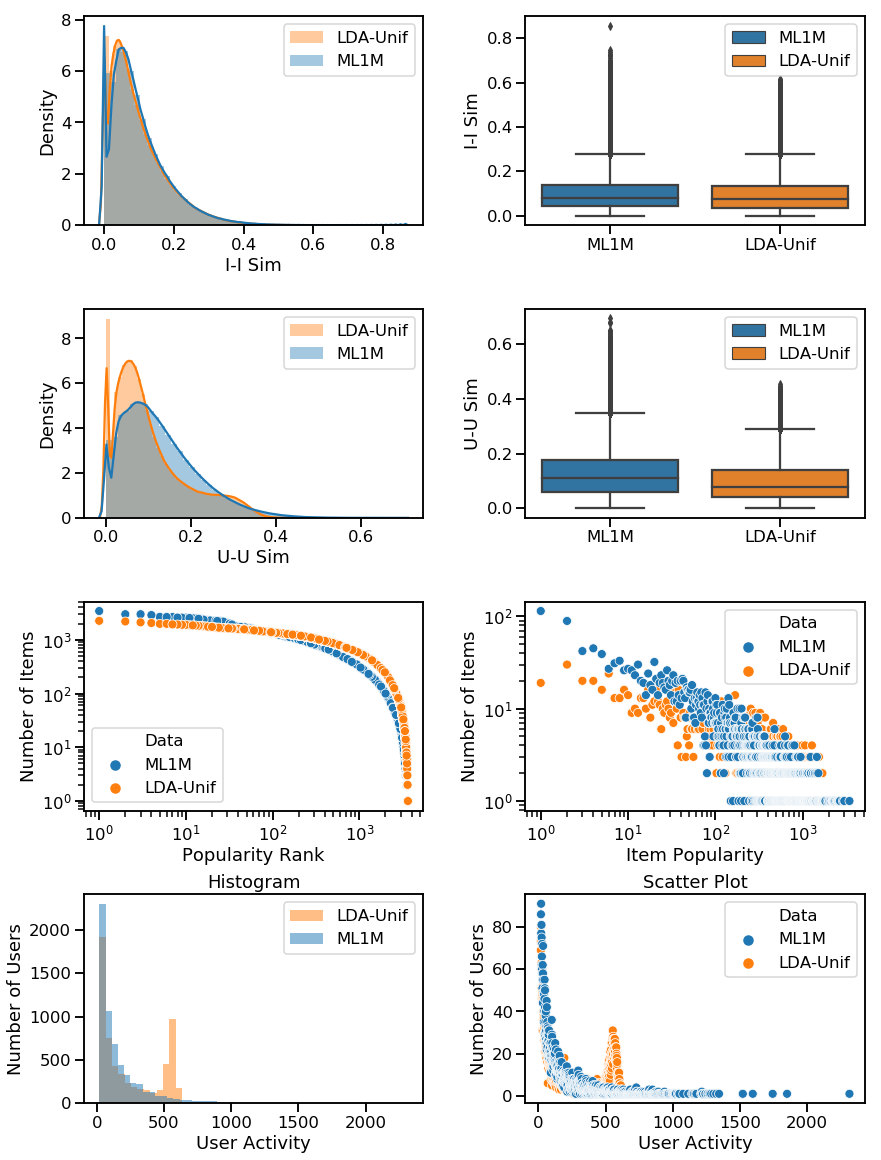

In [18]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-ml_1m-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-ml_1m-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ML1M', ml_1m), ('LDA-Unif', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif_csr-ml_1m-icorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('LDA-Unif', simulated_data), mrated=5)

### lda unif on item pop

[5, 216.02025435082638, 1.0, 0.14446127720499327, 20.646632407548296, 0.1, 2776.7999999999997] 0.40835697173809504
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  LDA-Unif    6040    3648   802532  0.036423
item popularity stats
              ML1M     LDA-Unif
count  3706.000000  3648.000000
mean    269.889099   219.992325
std     384.047838   234.832583
min       1.000000     1.000000
25%      33.000000    48.000000
50%     123.500000   145.000000
75%     350.000000   311.250000
max    3428.000000  2013.000000
user profile stats
              ML1M     LDA-Unif
count  6040.000000  6040.000000
mean    165.597517   132.869536
std     192.747029    71.237228
min      20.000000    20.000000
25%      44.000000    56.000000
50%      96.000000   169.000000
75%     208.000000   197.000000
max    2314.000000   261.000000


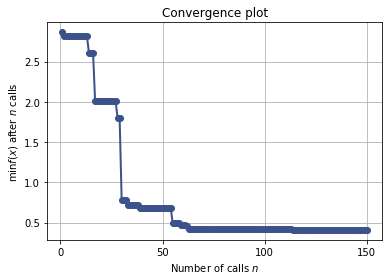

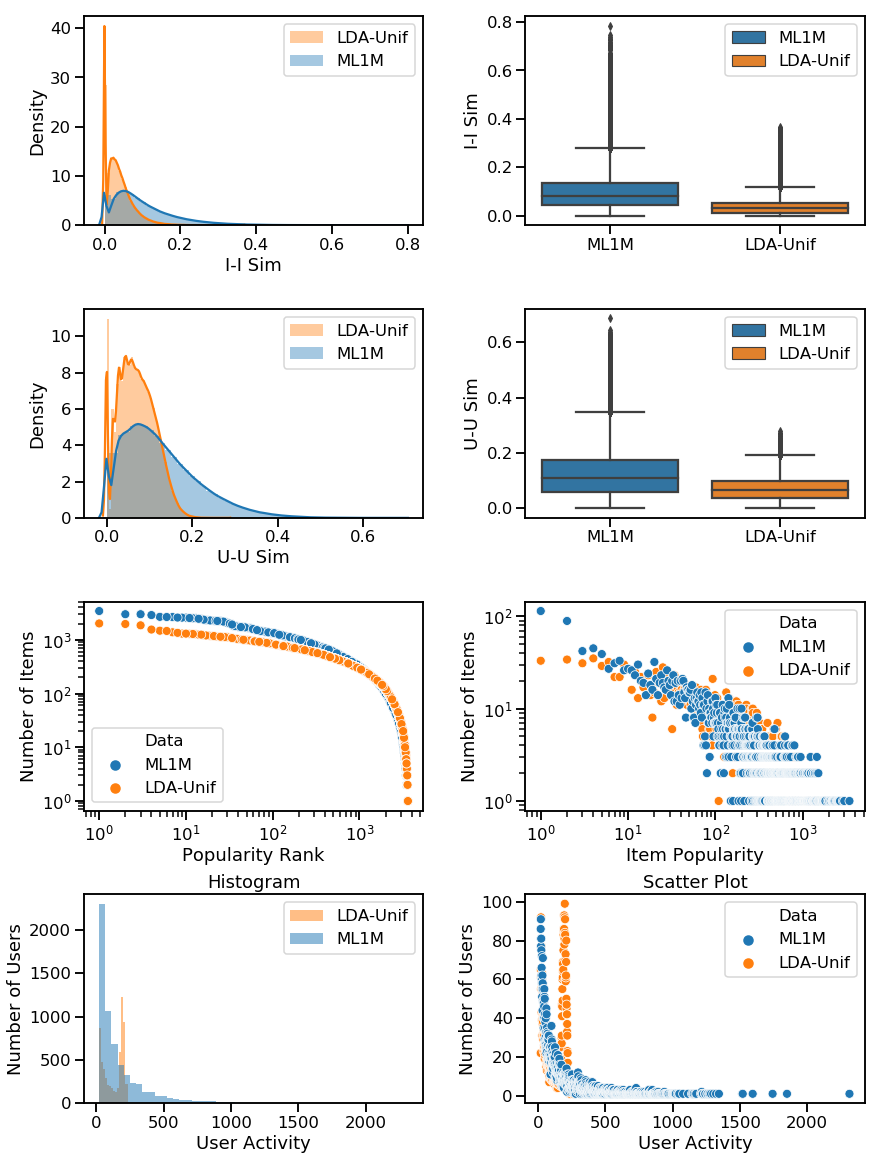

In [19]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-ml_1m-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-ml_1m-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ML1M', ml_1m), ('LDA-Unif', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif_csr-ml_1m-item-pop.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('LDA-Unif', simulated_data), mrated=5)

### lda unif on user activity

[156, 2000.0, 1.0, 0.389266609384339, 20.174773675841674, 0.1, 1851.2] 0.28116081820943595
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  LDA-Unif    6040    3706  2118692  0.094651
item popularity stats
              ML1M     LDA-Unif
count  3706.000000  3706.000000
mean    269.889099   571.692391
std     384.047838    59.104677
min       1.000000   384.000000
25%      33.000000   531.000000
50%     123.500000   572.000000
75%     350.000000   611.000000
max    3428.000000   774.000000
user profile stats
              ML1M     LDA-Unif
count  6040.000000  6040.000000
mean    165.597517   350.776821
std     192.747029   425.191673
min      20.000000    20.000000
25%      44.000000    50.000000
50%      96.000000   147.000000
75%     208.000000   503.250000
max    2314.000000  1635.000000


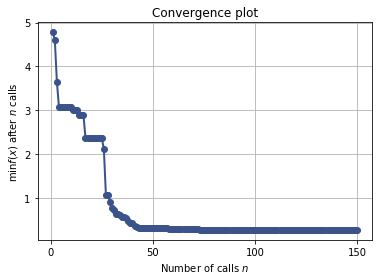

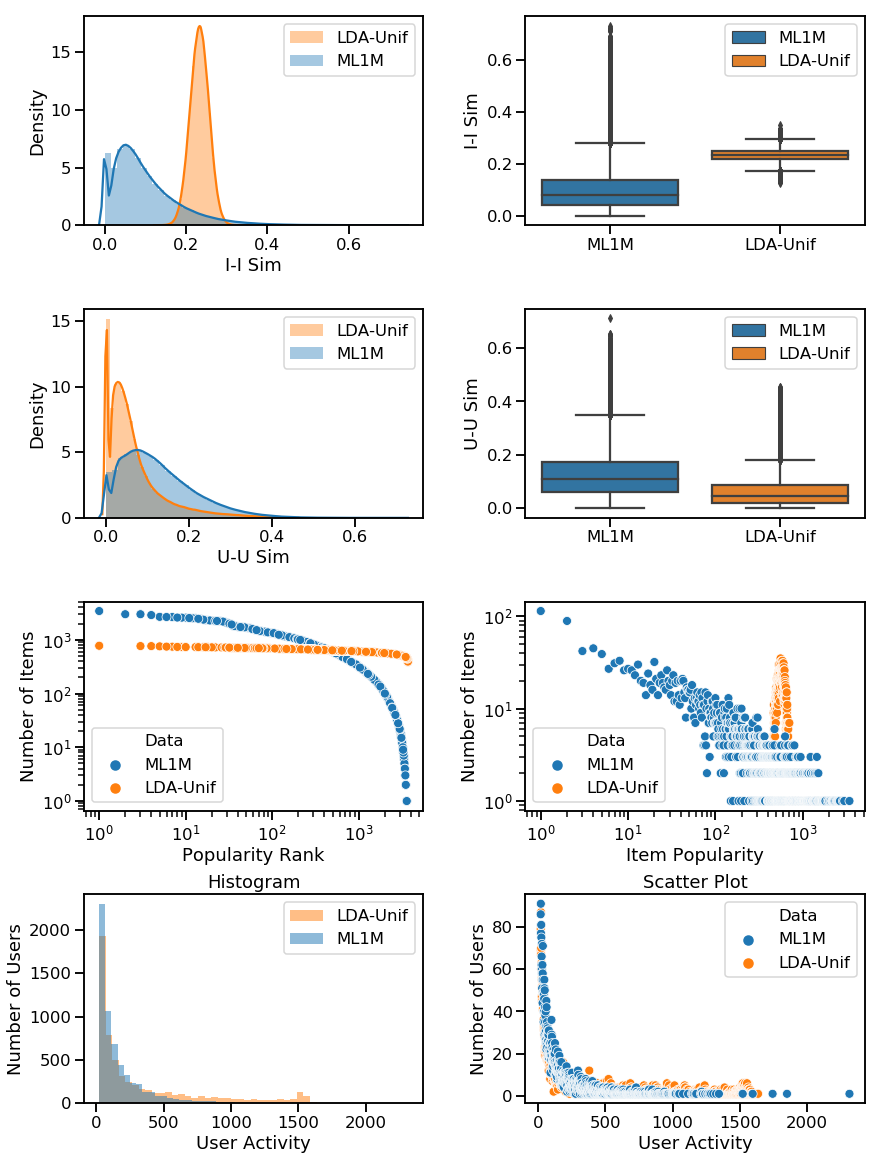

In [20]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-ml_1m-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-ml_1m-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ML1M', ml_1m), ('LDA-Unif', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif_csr-ml_1m-user-act.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('LDA-Unif', simulated_data), mrated=5)

### lda unif on relative loss

In [21]:
search_space('build/gp_minimize_lda_unif_csr-ml_1m-ucorr.pkl')
search_space('build/skopt_lda_unif-ml_1m.pkl')

('k', (5.0, 200.0)) ('lambda', (5.000000000000001, 2000.0)) ('a', (0.01, 1.0)) ('b', (0.01, 1.0)) ('m', (16.0, 24.0)) ('alpha', (0.1, 20.0)) ('upper', (1851.2, 2776.7999999999997)) 0.039165975389915404
('k', (5.0, 200.0)) ('lambda', (5.180369414899985, 2000.0)) ('a', (0.017039928810750553, 0.9999783651116403)) ('b', (0.01, 1.0)) ('m', (16.056340904073014, 24.0)) ('alpha', (0.1, 18.5062039236493)) ('upper', (51.575398762697034, 2776.7999999999997)) 17.24649410803431


[5, 2000.0, 0.7434914655336458, 0.06081143092027172, 24.0, 0.1, 2776.7999999999997] 17.24649410803431
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  LDA-Unif    6040    3447  2034037  0.097697
item popularity stats
              ML1M     LDA-Unif
count  3706.000000  3447.000000
mean    269.889099   590.089063
std     384.047838   608.526803
min       1.000000     1.000000
25%      33.000000    61.000000
50%     123.500000   358.000000
75%     350.000000  1009.500000
max    3428.000000  2315.000000
user profile stats
              ML1M     LDA-Unif
count  6040.000000  6040.000000
mean    165.597517   336.761093
std     192.747029   319.613567
min      20.000000    24.000000
25%      44.000000    66.000000
50%      96.000000   185.500000
75%     208.000000   634.000000
max    2314.000000  1009.000000


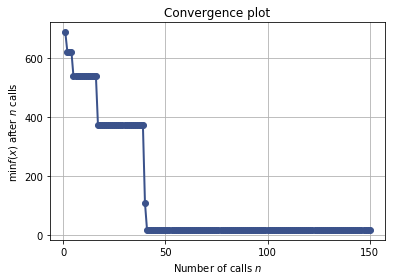

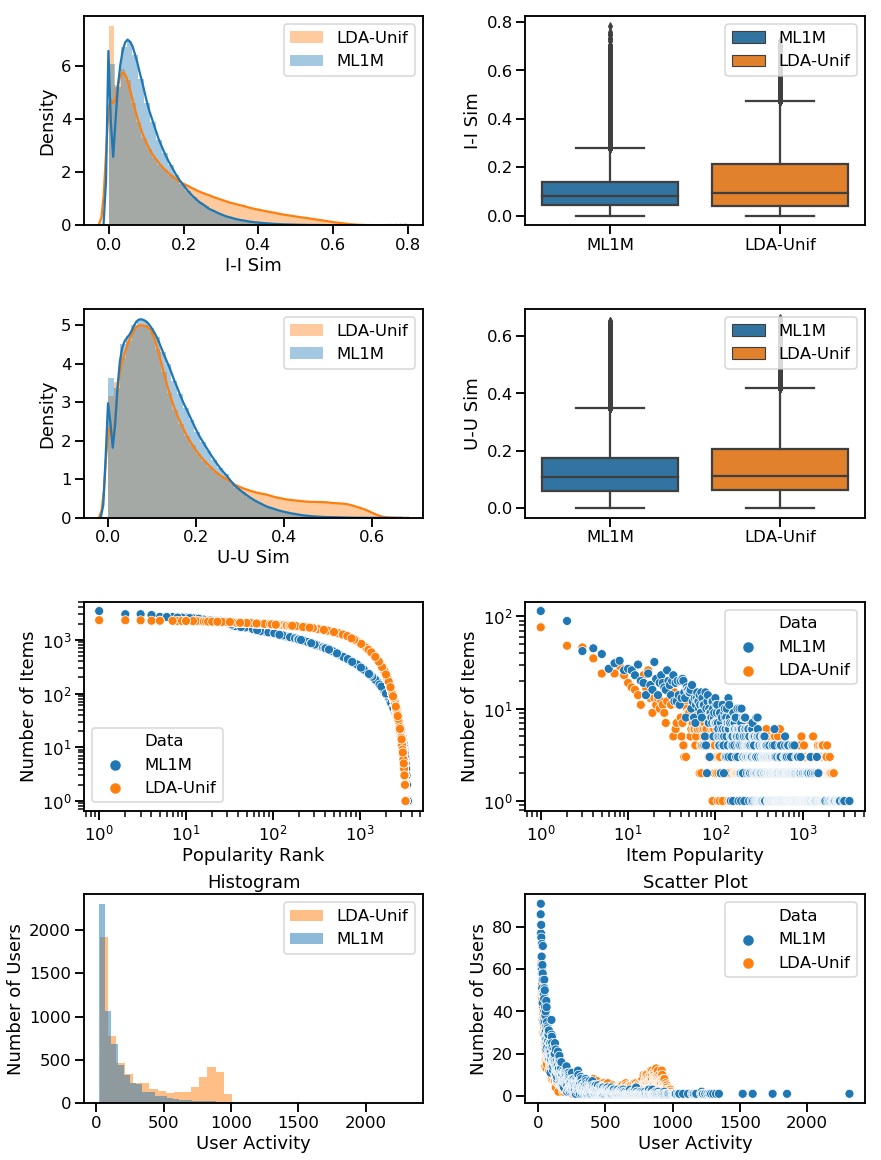

In [22]:
res_gp = skopt.load('build/skopt_lda_unif-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif-ml_1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif-ml_1m.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('LDA-Unif', simulated_data), mrated=5)

### lda pop on item item

In [23]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-icorr-1-2019-04-07-21-16-39.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))))
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-icorr.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))))

[(10.0, 100.0), (5.000000000000001, 2000.0), (0.01, 1.0), (0.01, 1.0), (18.0, 22.0), (0.1, 20.0), (2082.600000000001, 2545.4)]
[(5.0, 200.0), (5.000000000000001, 2000.0), (0.01, 1.0), (0.01, 1.0), (16.0, 24.0), (0.1, 20.0), (1851.2, 2776.7999999999997)]


[55, 794.005661238729, 0.9272175921843728, 0.01, 18.39948346586445, 0.1, 2440.083506802689] 0.0022155974149804603
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  LDA-Pop    6040    3608  1492625  0.068493
item popularity stats
              ML1M      LDA-Pop
count  3706.000000  3608.000000
mean    269.889099   413.698725
std     384.047838   488.845748
min       1.000000     1.000000
25%      33.000000    53.000000
50%     123.500000   218.000000
75%     350.000000   595.000000
max    3428.000000  2917.000000
user profile stats
              ML1M      LDA-Pop
count  6040.000000  6040.000000
mean    165.597517   247.123344
std     192.747029   216.282119
min      20.000000    18.000000
25%      44.000000    50.000000
50%      96.000000   153.500000
75%     208.000000   525.000000
max    2314.000000   621.000000


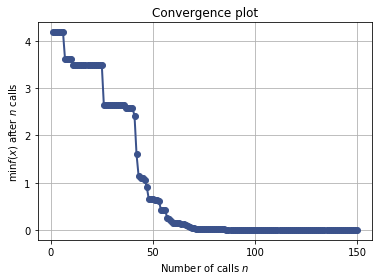

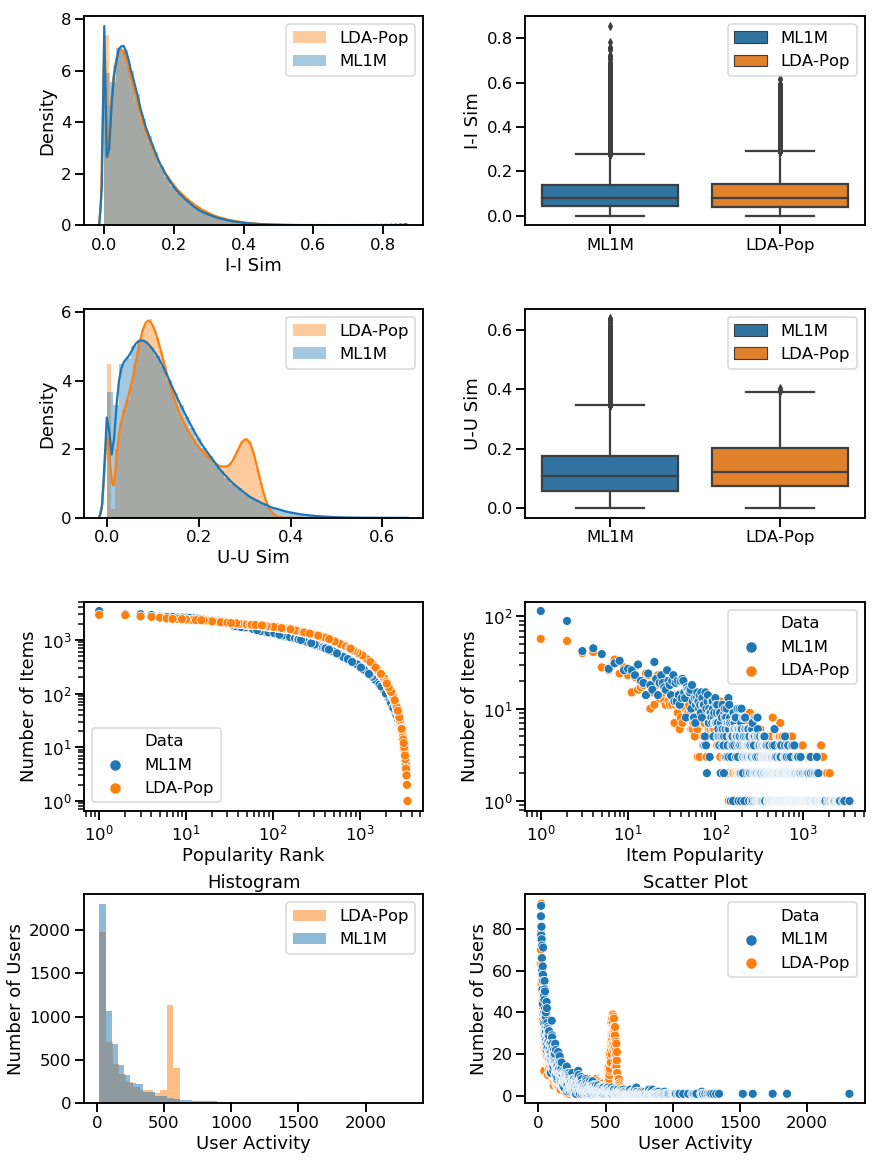

In [24]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-ml_1m-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop_csr-ml_1m-icorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('LDA-Pop', simulated_data), mrated=5)

### lda pop on user user

In [25]:
search_space('build/gp_minimize_lda_pop_csr-ml_1m-ucorr.pkl')

('k', (5.0, 200.0)) ('lambda', (5.000000000000001, 2000.0)) ('a', (0.01, 1.0)) ('b', (0.01, 1.0)) ('m', (16.0, 24.0)) ('alpha', (0.1, 20.0)) ('upper', (1851.2, 2776.7999999999997)) 0.018393478110145037


[5, 186.41487274303788, 0.24370274539930467, 0.04729917760905374, 19.555016699895862, 0.1, 2718.6920629824003] 0.018393478110145037
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  LDA-Pop    6040    2926   640875  0.036263
item popularity stats
              ML1M      LDA-Pop
count  3706.000000  2926.000000
mean    269.889099   219.027683
std     384.047838   350.851119
min       1.000000     1.000000
25%      33.000000    12.000000
50%     123.500000    66.000000
75%     350.000000   267.750000
max    3428.000000  2794.000000
user profile stats
              ML1M      LDA-Pop
count  6040.000000  6040.000000
mean    165.597517   106.105132
std     192.747029    49.730571
min      20.000000    19.000000
25%      44.000000    54.000000
50%      96.000000   129.000000
75%     208.000000   147.000000
max    2314.000000   187.000000


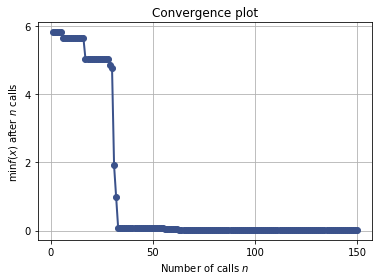

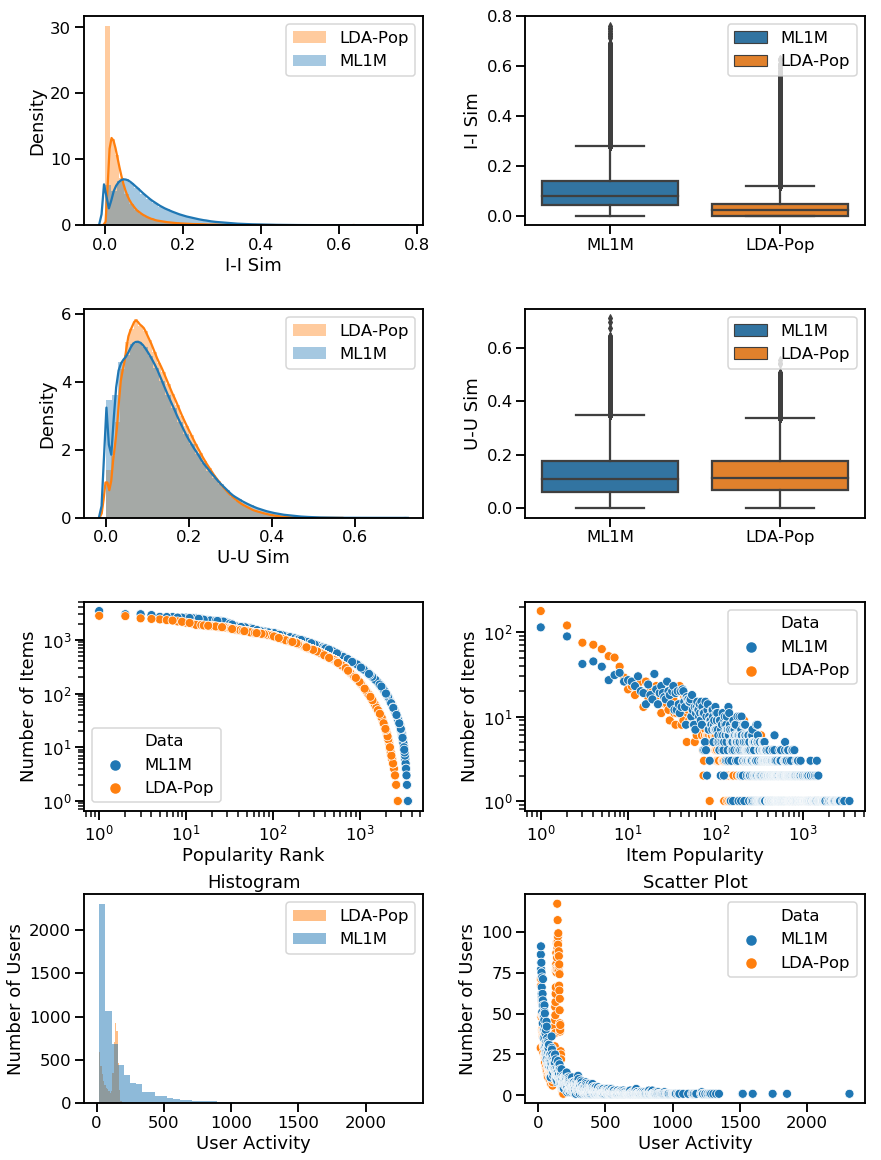

In [26]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-ml_1m-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ML1M', ml_1m), ('LDA-Pop', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop_csr-ml_1m-ucorr'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('LDA-Pop', simulated_data), mrated=5)

### lda pop on item pop

[78, 240.221761304063, 1.0, 0.01, 24.0, 0.1, 2776.7999999999997] 0.4016609188511891
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  LDA-Pop    6040    3651   890619  0.040387
item popularity stats
              ML1M      LDA-Pop
count  3706.000000  3651.000000
mean    269.889099   243.938373
std     384.047838   276.391817
min       1.000000     1.000000
25%      33.000000    48.500000
50%     123.500000   141.000000
75%     350.000000   343.500000
max    3428.000000  2123.000000
user profile stats
              ML1M      LDA-Pop
count  6040.000000  6040.000000
mean    165.597517   147.453477
std     192.747029    77.511528
min      20.000000    24.000000
25%      44.000000    64.000000
50%      96.000000   189.500000
75%     208.000000   216.000000
max    2314.000000   267.000000


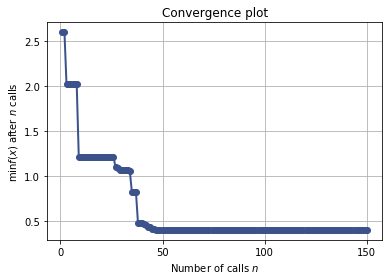

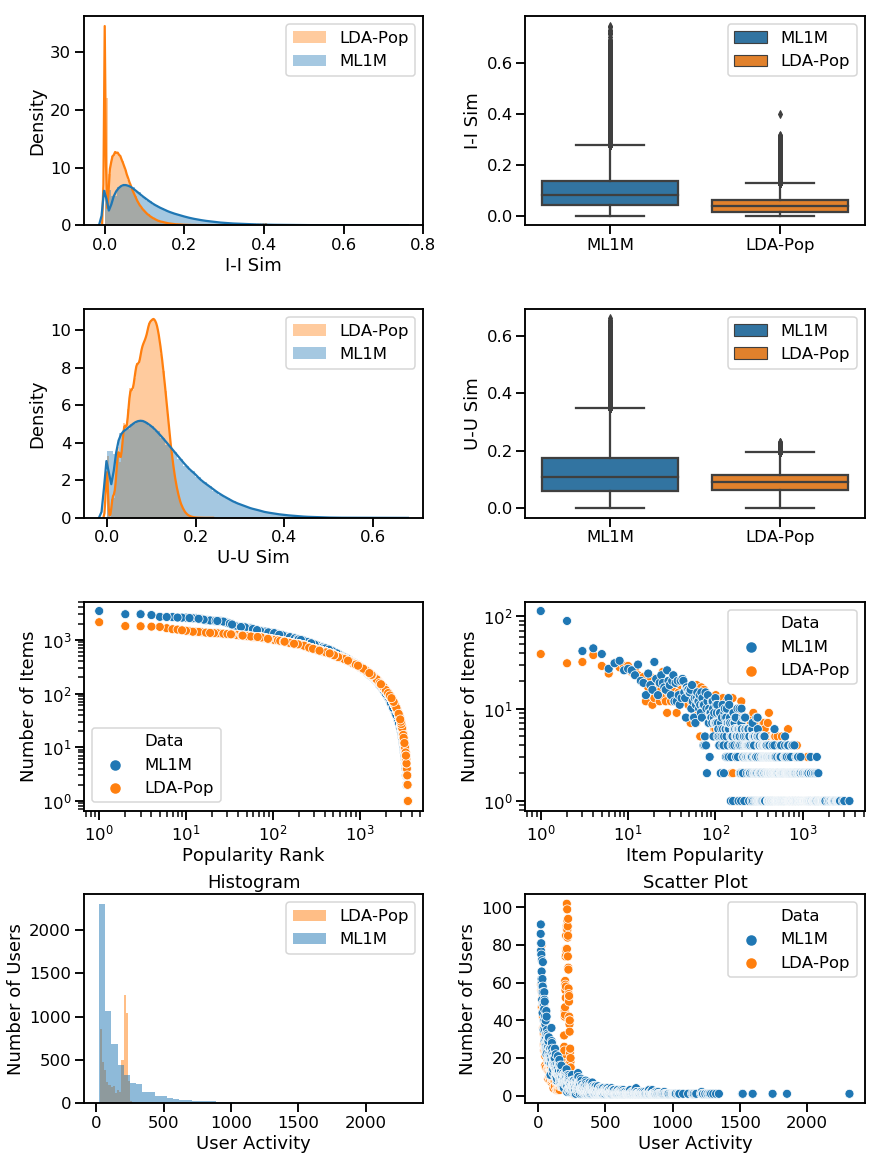

In [27]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-ml_1m-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ML1M', ml_1m), ('LDA-Pop', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop_csr-ml_1m-item-pop.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('LDA-Pop', simulated_data), mrated=5)

### lda pop on user activity

[189, 2000.0, 0.01, 0.01, 20.638817140789776, 0.3665290127039441, 1851.2] 0.22130106386986026
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  LDA-Pop    6040    3706   948377  0.042368
item popularity stats
              ML1M      LDA-Pop
count  3706.000000  3706.000000
mean    269.889099   255.903130
std     384.047838   136.486223
min       1.000000     4.000000
25%      33.000000   156.000000
50%     123.500000   237.000000
75%     350.000000   333.000000
max    3428.000000  1100.000000
user profile stats
              ML1M      LDA-Pop
count  6040.000000  6040.000000
mean    165.597517   157.016060
std     192.747029   154.193905
min      20.000000    20.000000
25%      44.000000    37.000000
50%      96.000000    82.000000
75%     208.000000   252.000000
max    2314.000000   678.000000


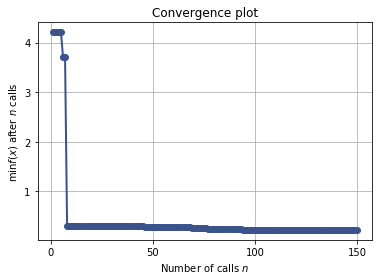

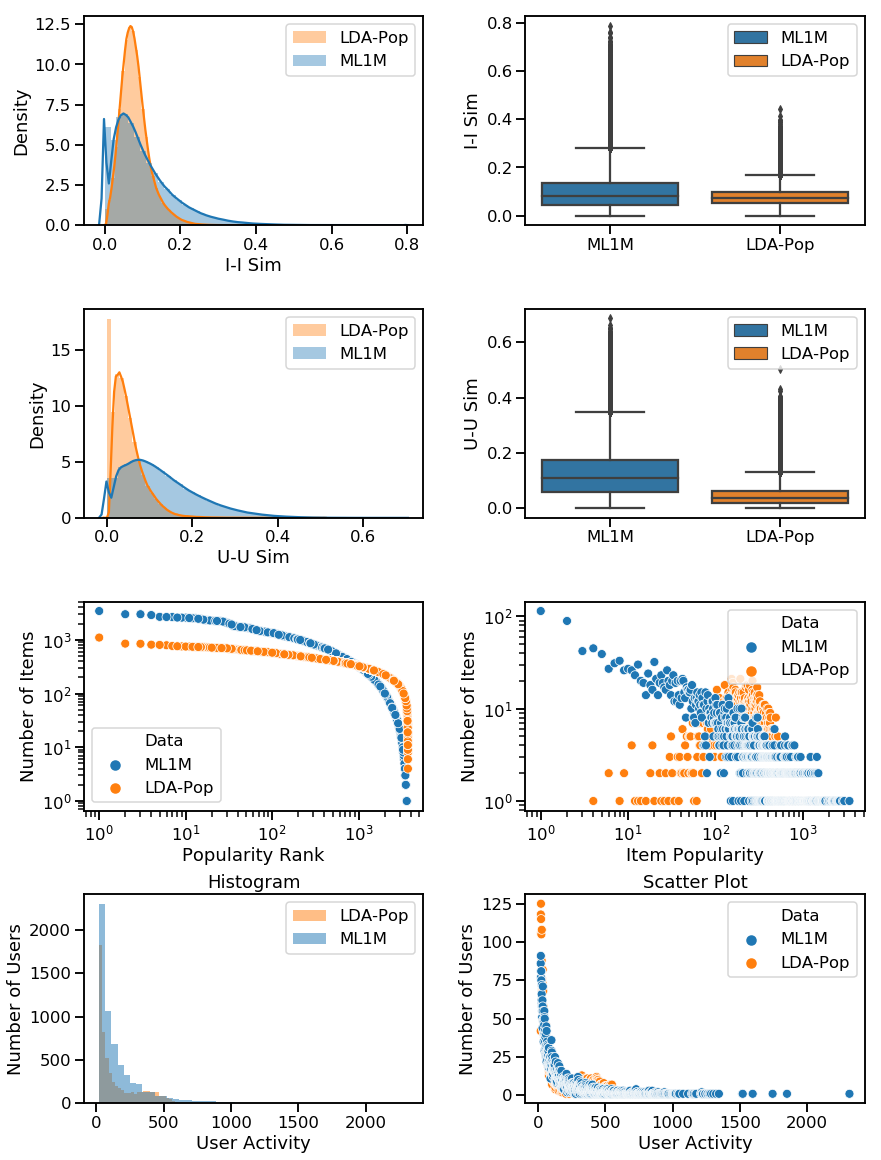

In [28]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-ml_1m-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop_csr-ml_1m-user-act.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('LDA-Pop', simulated_data), mrated=5)

### lda pop on relative loss

In [29]:
search_space('build/skopt_lda_pop-ml_1m.pkl')

('k', (5.0, 193.0)) ('lambda', (5.123311155289161, 2000.0)) ('a', (0.011842490837144417, 1.0)) ('b', (0.01, 0.9127710242768335)) ('m', (16.80294825982477, 24.0)) ('alpha', (0.1, 19.12590079670633)) ('upper', (51.07778377747637, 2776.7999999999997)) 10.738404717050713


[5, 1159.8329177122407, 1.0, 0.01, 24.0, 1.4616187892946093, 2776.7999999999997] 10.738404717050713
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  LDA-Pop    6040    1100   364066  0.054796
item popularity stats
              ML1M      LDA-Pop
count  3706.000000  1100.000000
mean    269.889099   330.969091
std     384.047838   474.511889
min       1.000000     1.000000
25%      33.000000     5.000000
50%     123.500000    60.000000
75%     350.000000   484.500000
max    3428.000000  1746.000000
user profile stats
              ML1M      LDA-Pop
count  6040.000000  6040.000000
mean    165.597517    60.275828
std     192.747029    57.837623
min      20.000000    24.000000
25%      44.000000    29.000000
50%      96.000000    39.000000
75%     208.000000    63.000000
max    2314.000000   357.000000


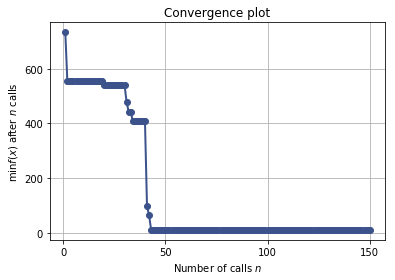

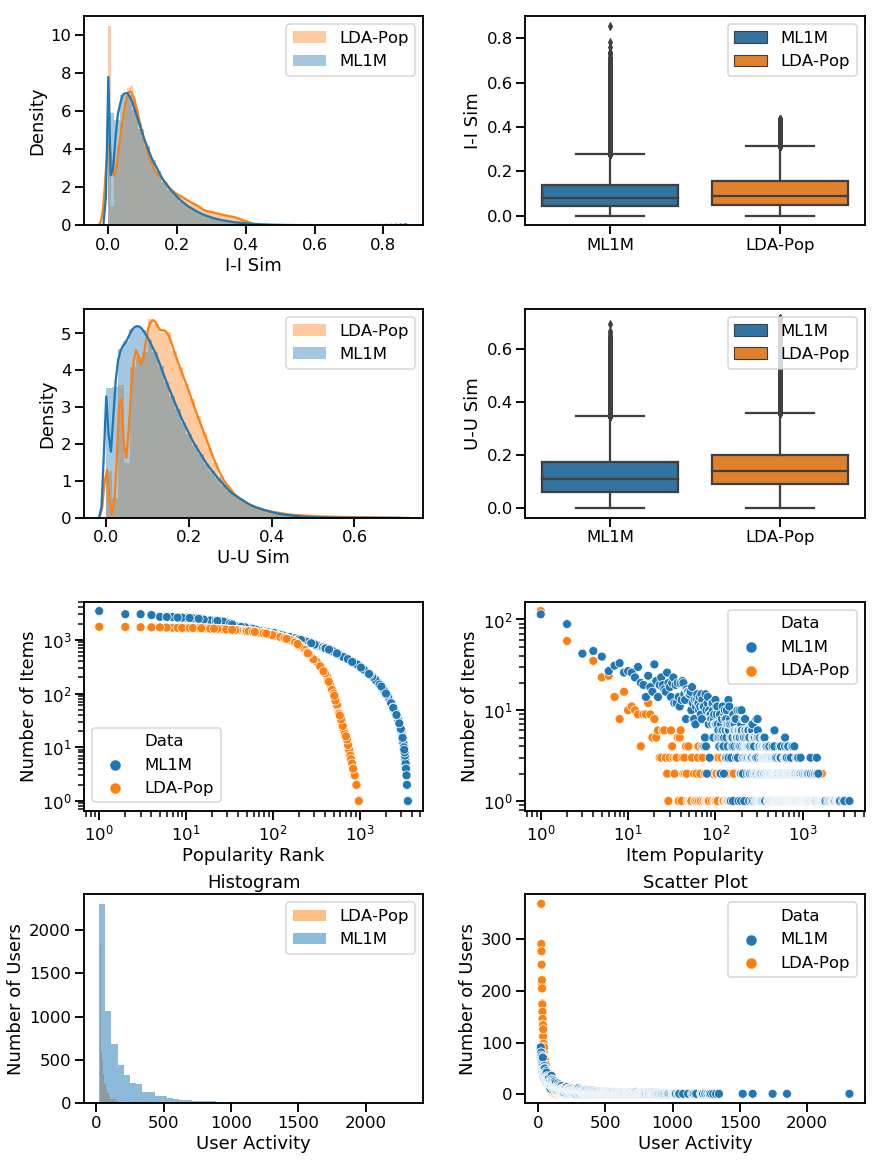

In [30]:
res_gp = skopt.load('build/skopt_lda_pop-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop-ml_1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ML1M', ml_1m), ('LDA-Pop', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop-ml_1m.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('LDA-Pop', simulated_data), mrated=5)

### ibp unif on item item

In [31]:
search_space('build/gp_minimize_ibp_unif_csr-ml_1m-icorr.pkl')

('alpha', (20.000000000000004, 1000.0)) ('c', (0.01, 100.0)) ('sigma', (0.0, 0.99)) ('m', (16.0, 24.0)) ('alpha', (0.1, 20.0)) ('upper', (1851.2, 2776.7999999999997)) 0.11534920303693451


[1000.0, 0.5540472537357217, 0.0, 16.0, 0.6957790463212584, 2062.536996439869] 0.11534920303693451
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  IBP-Unif    6040    4584   718874  0.025964
item popularity stats
              ML1M     IBP-Unif
count  3706.000000  4584.000000
mean    269.889099   156.822426
std     384.047838   217.658120
min       1.000000     1.000000
25%      33.000000     5.000000
50%     123.500000    36.000000
75%     350.000000   247.000000
max    3428.000000   749.000000
user profile stats
              ML1M     IBP-Unif
count  6040.000000  6040.000000
mean    165.597517   119.018874
std     192.747029   205.776969
min      20.000000    16.000000
25%      44.000000    23.000000
50%      96.000000    40.000000
75%     208.000000   102.250000
max    2314.000000  1061.000000


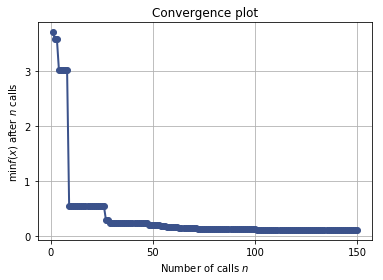

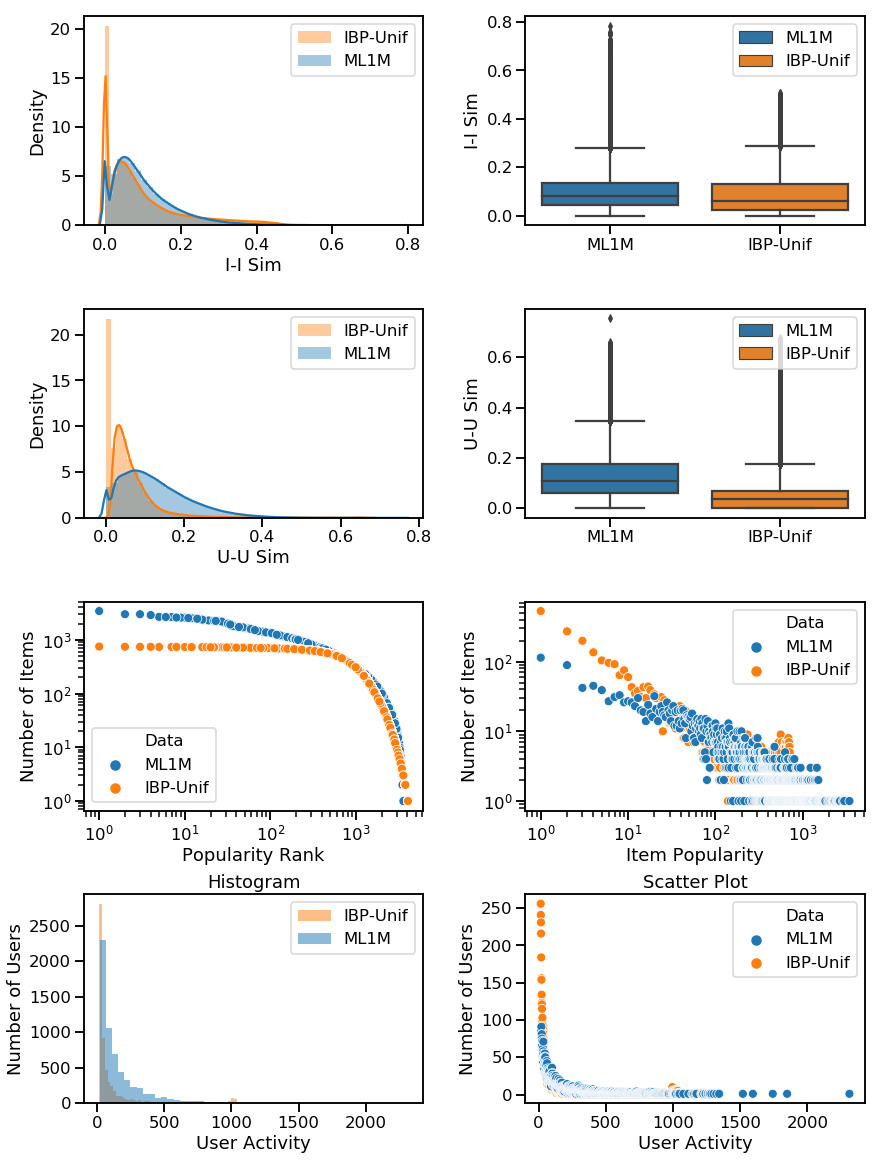

In [32]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-ml_1m-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif_csr-ml_1m-icorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Unif', simulated_data), mrated=5)

### ibp unif on user user

[351.42194561972684, 0.013118033403158681, 0.5422791900591778, 24.0, 0.6490494009412571, 2712.708552183093] 0.06009520051895485
simulated data is used


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  IBP-Unif    6040   25644   717176  0.004630
item popularity stats
              ML1M      IBP-Unif
count  3706.000000  25644.000000
mean    269.889099     27.966620
std     384.047838    162.549429
min       1.000000      1.000000
25%      33.000000      1.000000
50%     123.500000      1.000000
75%     350.000000      4.000000
max    3428.000000   2147.000000
user profile stats
              ML1M     IBP-Unif
count  6040.000000  6040.000000
mean    165.597517   118.737748
std     192.747029   110.345297
min      20.000000    24.000000
25%      44.000000    36.000000
50%      96.000000    64.000000
75%     208.000000   169.000000
max    2314.000000   380.000000


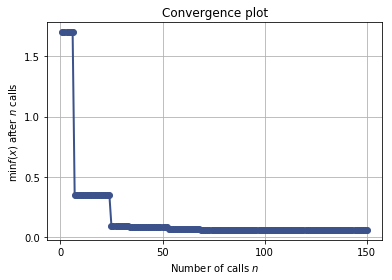

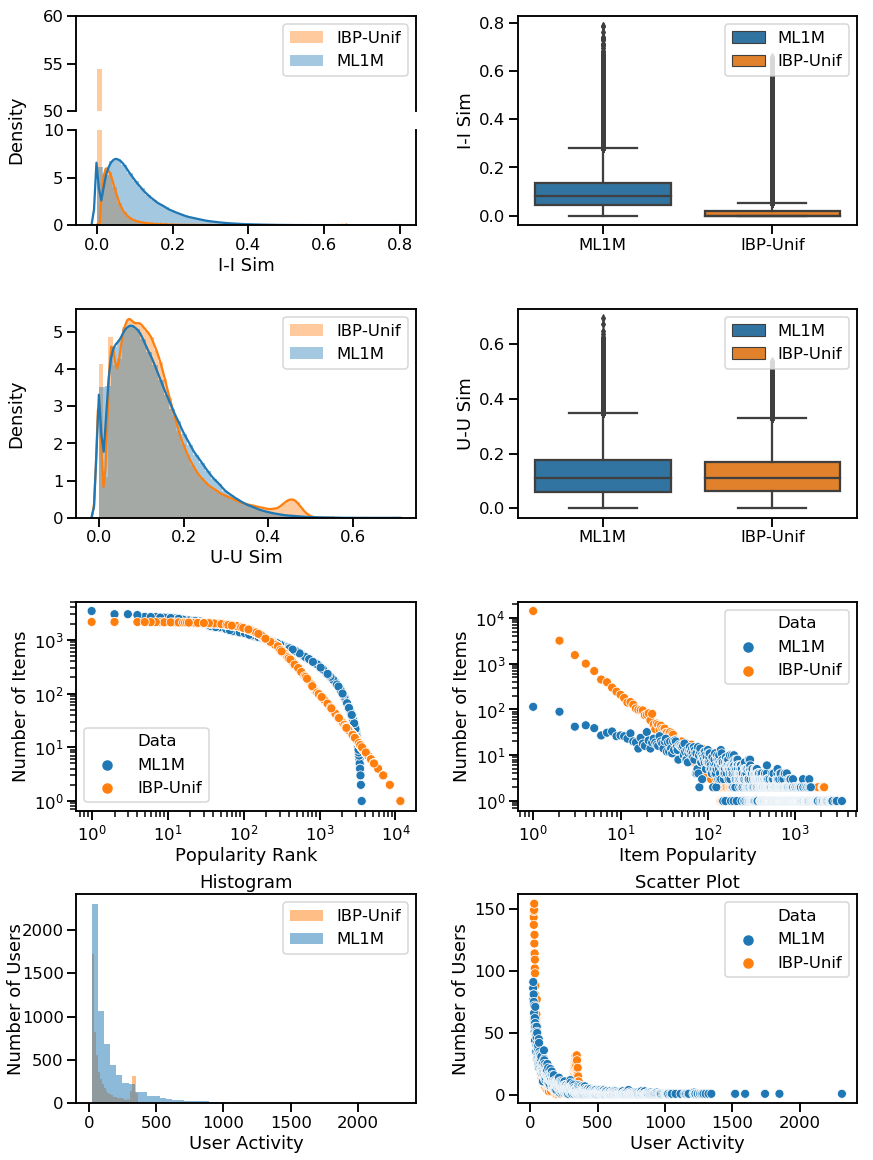

In [16]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-ml_1m-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif_csr-ml_1m-ucorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Unif', simulated_data), mrated=5, 
               ylim_left=((50, 60), (0, 10)))

### ibp unif on item pop

In [34]:
search_space('build/gp_minimize_ibp_unif_csr-ml_1m-item-pop.pkl')
search_space('build/gp_minimize_ibp_unif_csr-ml_1m-item-pop-1-2019-04-06-00-25-20.pkl')

('alpha', (10.0, 499.99999999999994)) ('c', (0.01, 100.0)) ('sigma', (0.0, 0.99)) ('m', (16.0, 24.0)) ('alpha', (0.1, 20.0)) ('upper', (1851.2, 2776.7999999999997)) 0.5226902837115196
('alpha', (20.000000000000004, 499.99999999999994)) ('c', (0.01, 100.0)) ('sigma', (0.0, 0.99)) ('m', (16.0, 24.0)) ('alpha', (0.1, 1000.0)) ('upper', (1851.2, 2776.7999999999997)) 0.1908084772090269


[10.0, 0.04952058484942609, 0.14071324462844437, 24.0, 20.0, 2776.7999999999997] 0.5226902837115196
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  IBP-Unif    6040      34    35055  0.170700
item popularity stats
              ML1M     IBP-Unif
count  3706.000000    34.000000
mean    269.889099  1031.029412
std     384.047838  1950.069066
min       1.000000     1.000000
25%      33.000000     4.500000
50%     123.500000    97.500000
75%     350.000000   630.250000
max    3428.000000  6040.000000
user profile stats
              ML1M     IBP-Unif
count  6040.000000  6040.000000
mean    165.597517     5.803808
std     192.747029     1.168423
min      20.000000     3.000000
25%      44.000000     5.000000
50%      96.000000     6.000000
75%     208.000000     7.000000
max    2314.000000    11.000000


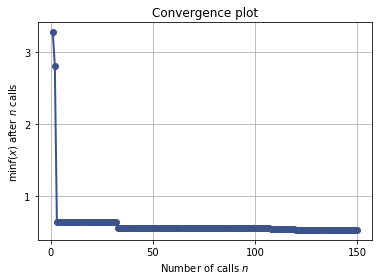

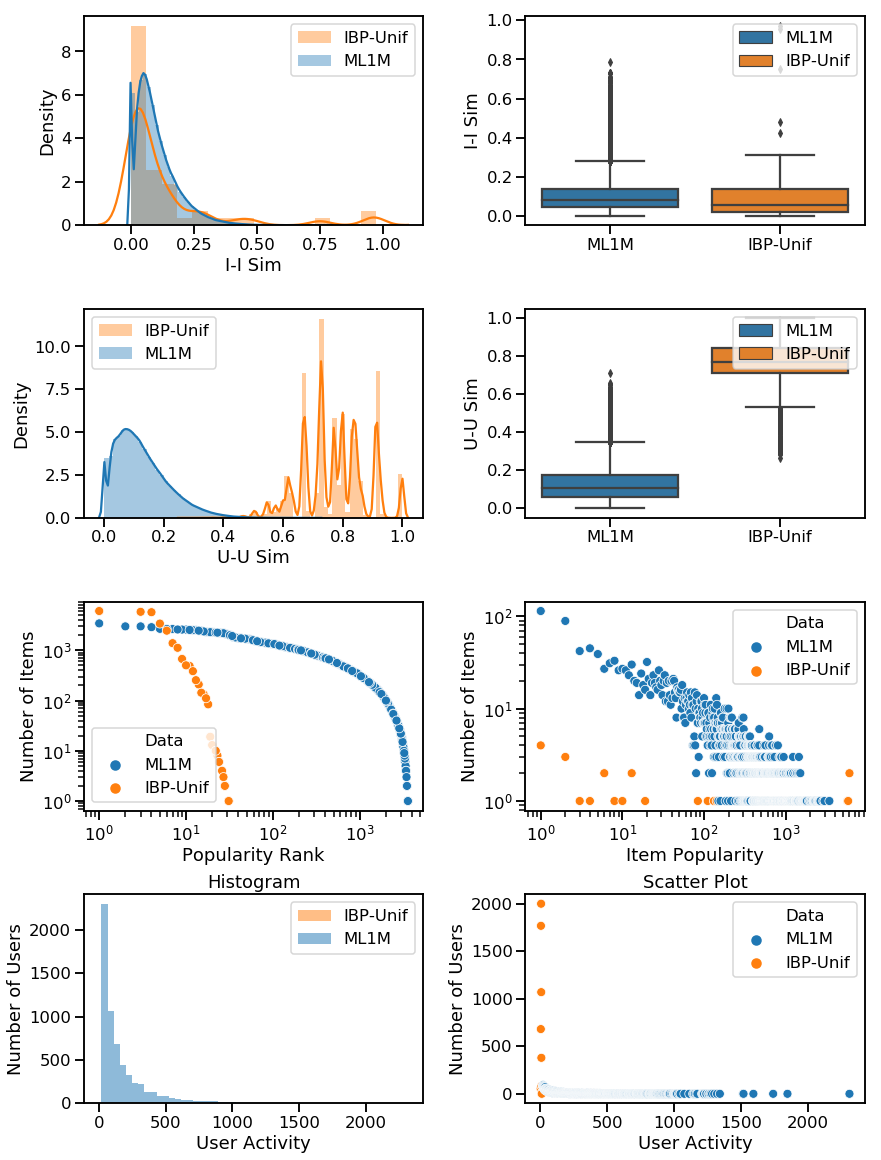

In [35]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-ml_1m-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ML1M', ml_1m), ('IBP-Unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif_csr-ml_1m-item-pop.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Unif', simulated_data), mrated=5)

### ibp unif on user activity

[966.0150686266583, 26.84734977306978, 0.9309527906300628, 20.30679034743485, 0.4044794359486432, 1851.2] 0.24486976031753746
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  IBP-Unif    6040  977574  1194465  0.000202
item popularity stats
              ML1M       IBP-Unif
count  3706.000000  977574.000000
mean    269.889099       1.221867
std     384.047838       1.878037
min       1.000000       1.000000
25%      33.000000       1.000000
50%     123.500000       1.000000
75%     350.000000       1.000000
max    3428.000000     189.000000
user profile stats
              ML1M     IBP-Unif
count  6040.000000  6040.000000
mean    165.597517   197.759106
std     192.747029   263.170979
min      20.000000    20.000000
25%      44.000000    36.000000
50%      96.000000    74.000000
75%     208.000000   224.000000
max    2314.000000  1037.000000


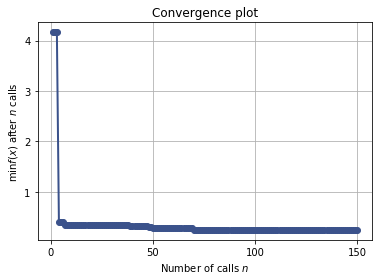

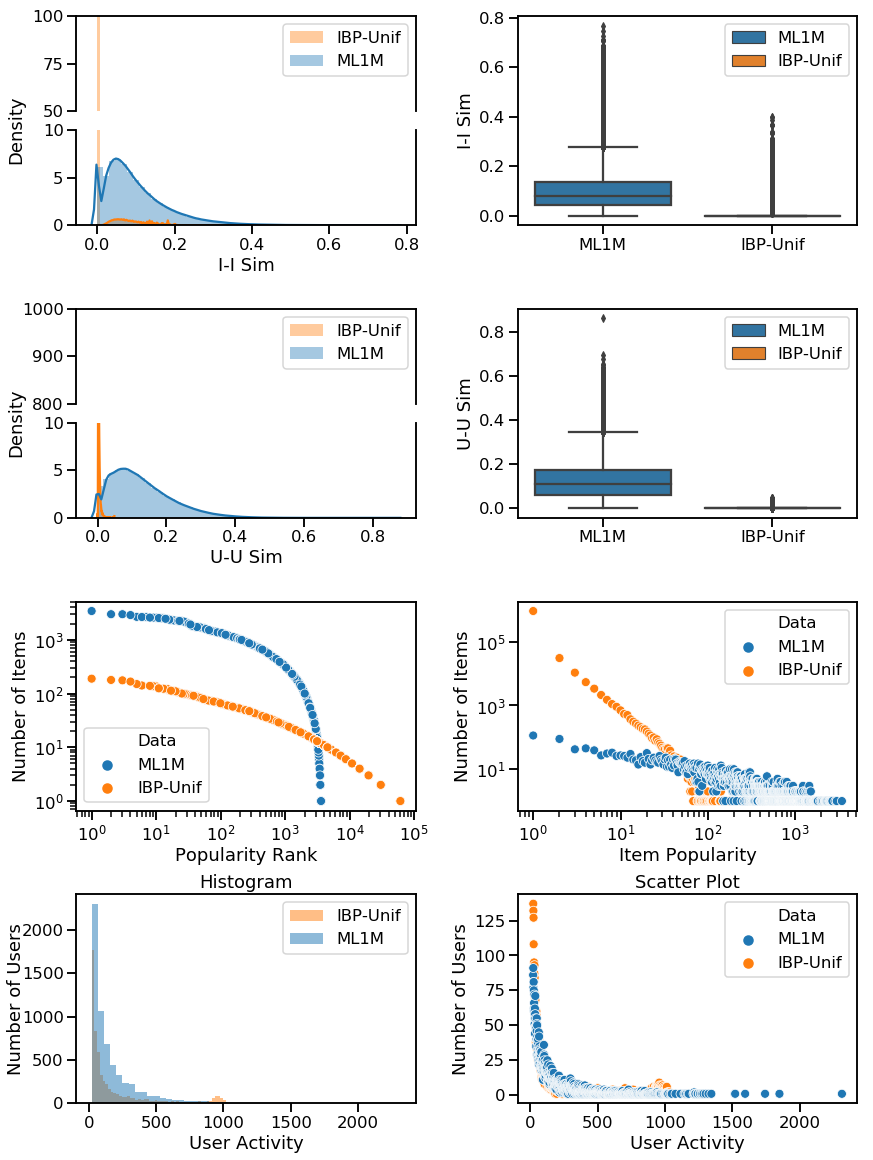

In [17]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-ml_1m-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif_csr-ml_1m-user-act.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Unif', simulated_data),
               ylim_left=((50, 100), (0, 10)), ylim_left2=((800, 1000), (0, 10)), mrated=5)

### ibp unif on relative loss

In [37]:
search_space('build/skopt_ibp_unif-ml_1m.pkl')

('alpha', (20.000000000000004, 2000.0)) ('c', (0.01, 100.0)) ('sigma', (0.0, 0.9816057345489767)) ('m', (16.0, 24.0)) ('alpha', (0.1, 19.680732502817143)) ('upper', (1851.2, 2776.7999999999997)) 22.660777239542437


[2000.0, 0.18697591393592916, 0.08870136506187663, 16.0, 0.1, 1871.1595857362172] 22.660777239542437
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  IBP-Unif    6040    7522  2032536  0.044737
item popularity stats
              ML1M     IBP-Unif
count  3706.000000  7522.000000
mean    269.889099   270.212178
std     384.047838   372.008532
min       1.000000     1.000000
25%      33.000000     4.000000
50%     123.500000    39.000000
75%     350.000000   497.750000
max    3428.000000  1123.000000
user profile stats
              ML1M     IBP-Unif
count  6040.000000  6040.000000
mean    165.597517   336.512583
std     192.747029   435.585238
min      20.000000    16.000000
25%      44.000000    43.000000
50%      96.000000   128.000000
75%     208.000000   453.000000
max    2314.000000  1866.000000


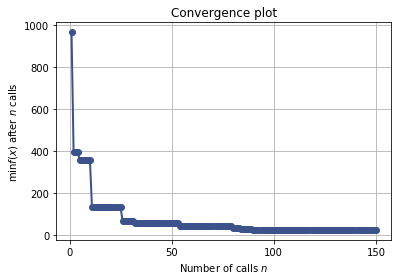

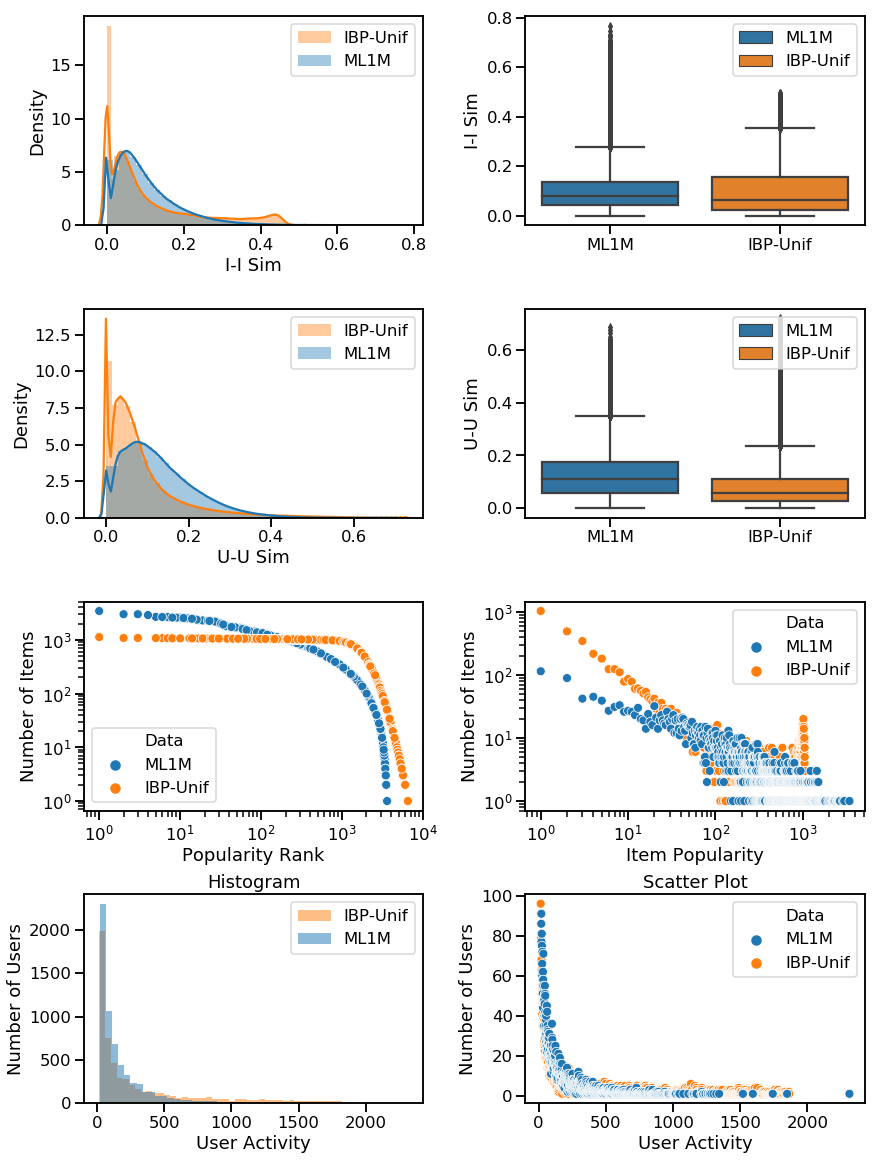

In [38]:
res_gp = skopt.load('build/skopt_ibp_unif-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif-ml1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif-ml1m.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Unif', simulated_data), mrated=5)

### ibp pop on item item

In [39]:
search_space('build/gp_minimize_ibp_pop_csr-ml_1m-icorr.pkl')

('alpha', (20.000000000000004, 1000.0)) ('c', (0.01, 100.0)) ('sigma', (0.0, 0.99)) ('m', (16.0, 24.0)) ('alpha', (0.1, 20.0)) ('upper', (1851.2, 2776.7999999999997)) 0.08944698170461593


[100.64074756946957, 0.596097151834829, 0.0, 16.0, 2.344538352190422, 1851.2] 0.08944698170461593
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  IBP-Pop    6040     370   160164  0.071668
item popularity stats
              ML1M      IBP-Pop
count  3706.000000   370.000000
mean    269.889099   432.875676
std     384.047838   712.268585
min       1.000000     1.000000
25%      33.000000     4.000000
50%     123.500000    40.000000
75%     350.000000   535.500000
max    3428.000000  2475.000000
user profile stats
              ML1M      IBP-Pop
count  6040.000000  6040.000000
mean    165.597517    26.517219
std     192.747029    15.030257
min      20.000000    16.000000
25%      44.000000    18.000000
50%      96.000000    21.000000
75%     208.000000    29.000000
max    2314.000000   108.000000


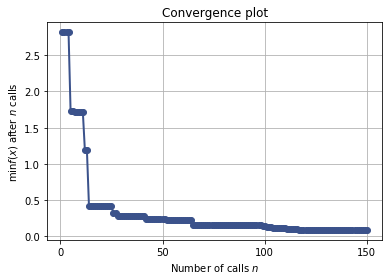

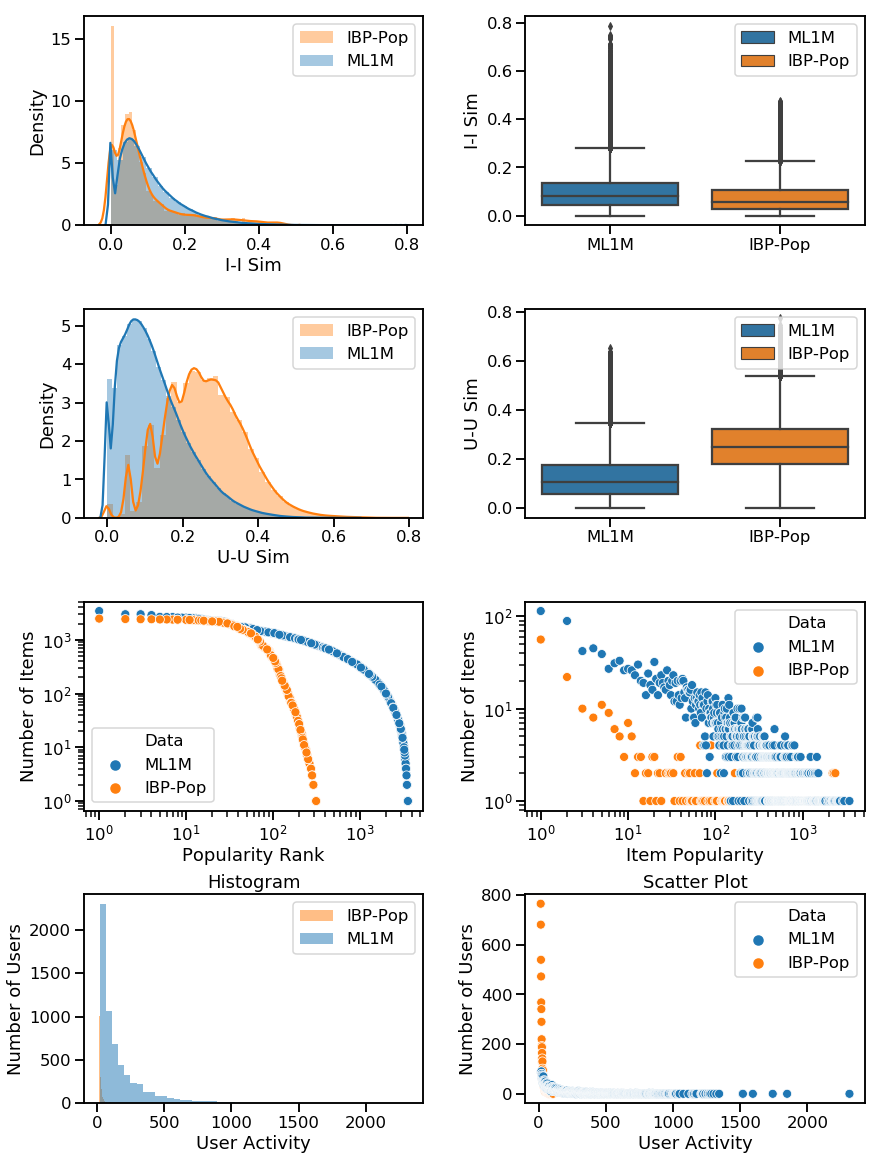

In [40]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-ml_1m-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop_csr-ml_1m-icorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Pop', simulated_data), mrated=5)

### ibp pop on user user

[1000.0, 1.5636046903580954, 0.0, 16.0, 0.1, 1851.2] 0.06492676332403066
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  IBP-Pop    6040    9905  1769728  0.029581
item popularity stats
              ML1M      IBP-Pop
count  3706.000000  9905.000000
mean    269.889099   178.670167
std     384.047838   383.368701
min       1.000000     1.000000
25%      33.000000     3.000000
50%     123.500000    17.000000
75%     350.000000   131.000000
max    3428.000000  2668.000000
user profile stats
              ML1M      IBP-Pop
count  6040.000000  6040.000000
mean    165.597517   293.001325
std     192.747029   333.150376
min      20.000000    16.000000
25%      44.000000    41.000000
50%      96.000000   126.000000
75%     208.000000   446.000000
max    2314.000000  1084.000000


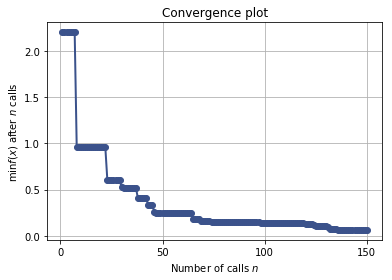

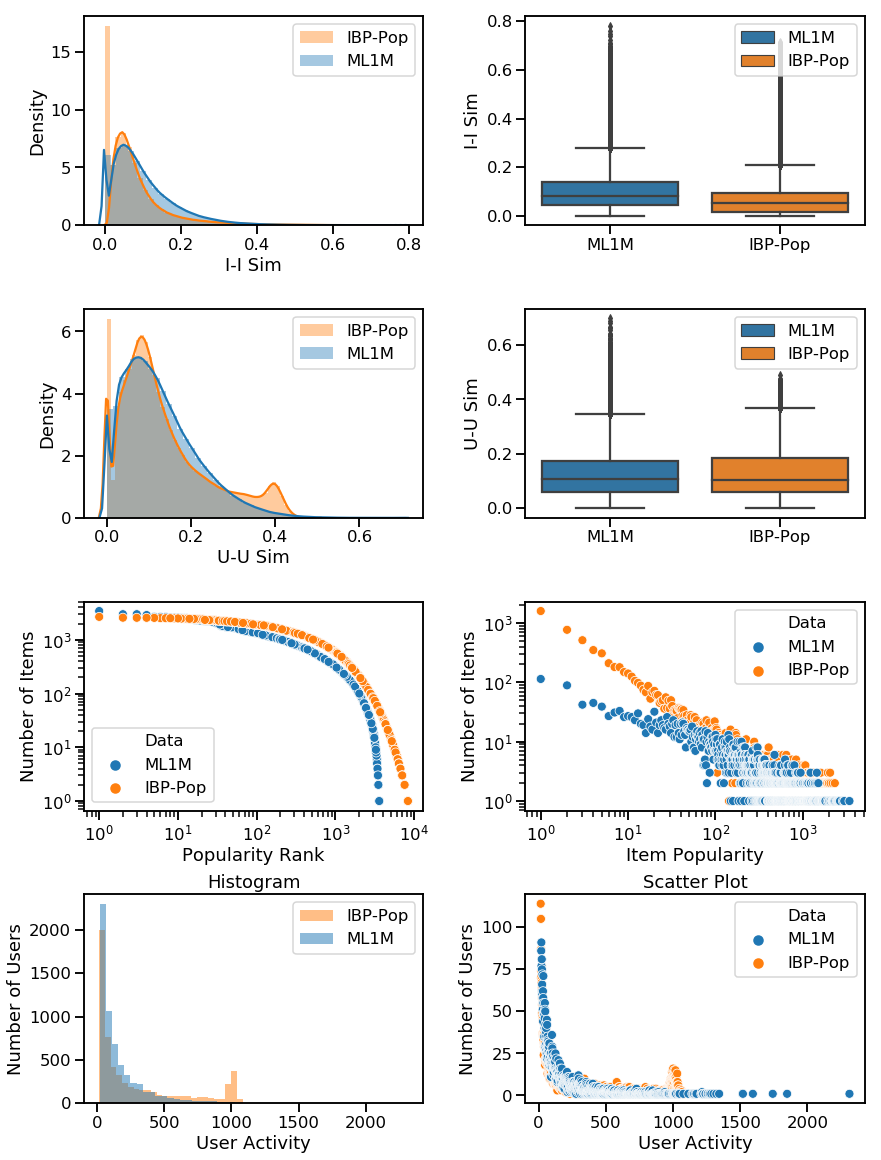

In [41]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-ml_1m-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop_csr-ml_1m-ucorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Pop', simulated_data), mrated=5)

### ibp pop on item pop

In [42]:
search_space('build/gp_minimize_ibp_pop_csr-ml_1m-item-pop-1-2019-04-05-20-35-30.pkl')

('alpha', (20.000000000000004, 4999.999999999999)) ('c', (0.01, 100.0)) ('sigma', (0.0, 0.99)) ('m', (18.0, 22.0)) ('alpha', (0.1, 1000.0)) ('upper', (2082.600000000001, 2545.4)) 0.19725351890396395


[20.000000000000004, 0.01, 0.11511074905581012, 24.0, 8.650942920202342, 2776.7999999999997] 0.5622671106909608
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  IBP-Pop    6040      60   110405  0.304650
item popularity stats
              ML1M      IBP-Pop
count  3706.000000    60.000000
mean    269.889099  1840.083333
std     384.047838  2450.266179
min       1.000000     1.000000
25%      33.000000     3.750000
50%     123.500000   171.500000
75%     350.000000  4690.500000
max    3428.000000  6040.000000
user profile stats
              ML1M      IBP-Pop
count  6040.000000  6040.000000
mean    165.597517    18.278974
std     192.747029     1.747467
min      20.000000    13.000000
25%      44.000000    17.000000
50%      96.000000    18.000000
75%     208.000000    19.000000
max    2314.000000    25.000000


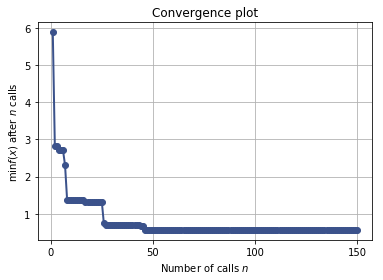

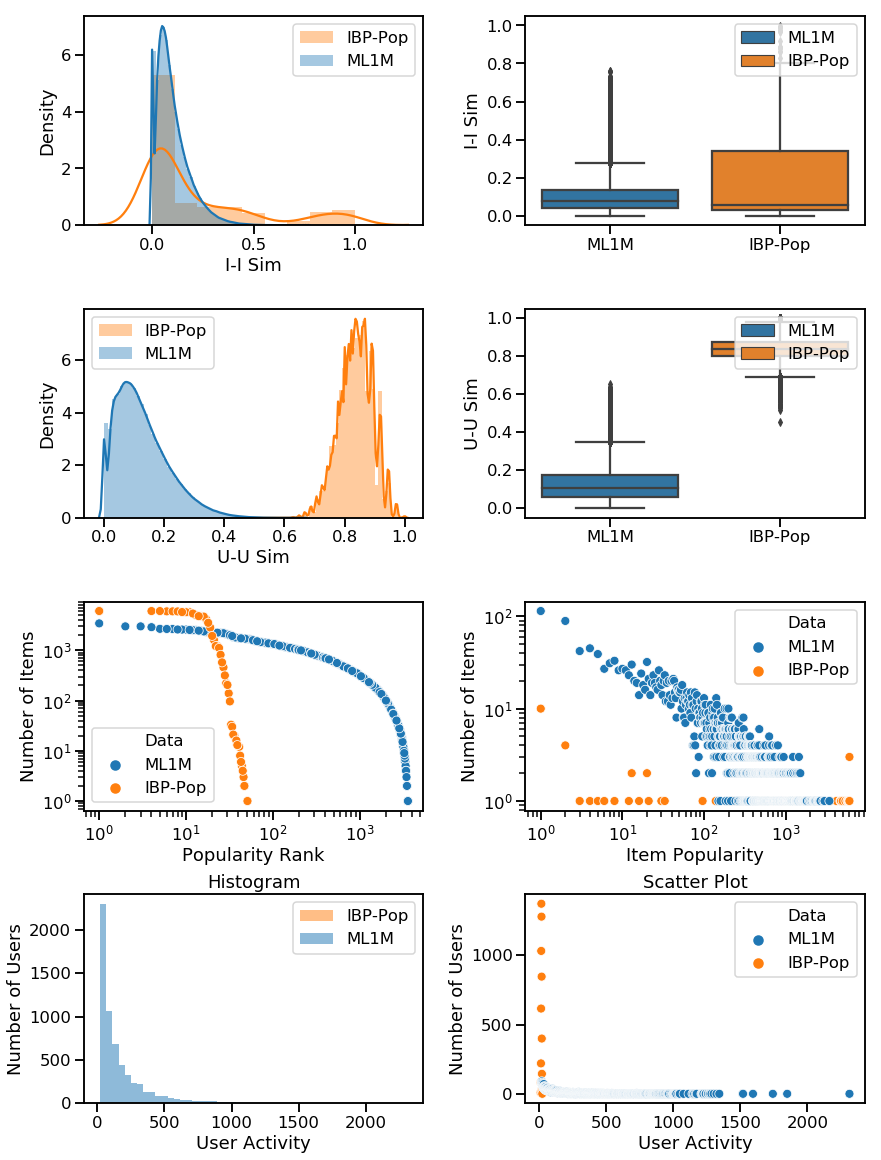

In [43]:
# retrain (lam 10 500)
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-ml_1m-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop_csr-ml_1m-item-pop.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Pop', simulated_data), mrated=5)

### ibp pop on user act

[990.7799437182746, 100.0, 0.5243207935764697, 20.756985106188516, 0.36157710559926626, 1851.2] 0.23709582878737792
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  IBP-Pop    6040  374268  1347153  0.000596
item popularity stats
              ML1M        IBP-Pop
count  3706.000000  374268.000000
mean    269.889099       3.599434
std     384.047838       7.867699
min       1.000000       1.000000
25%      33.000000       1.000000
50%     123.500000       1.000000
75%     350.000000       3.000000
max    3428.000000     286.000000
user profile stats
              ML1M      IBP-Pop
count  6040.000000  6040.000000
mean    165.597517   223.038576
std     192.747029   283.700076
min      20.000000    20.000000
25%      44.000000    38.000000
50%      96.000000    86.500000
75%     208.000000   278.000000
max    2314.000000  1095.000000


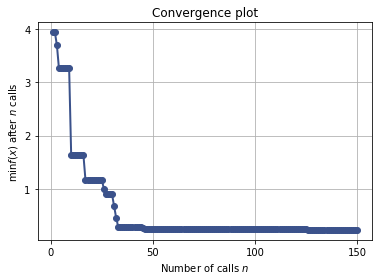

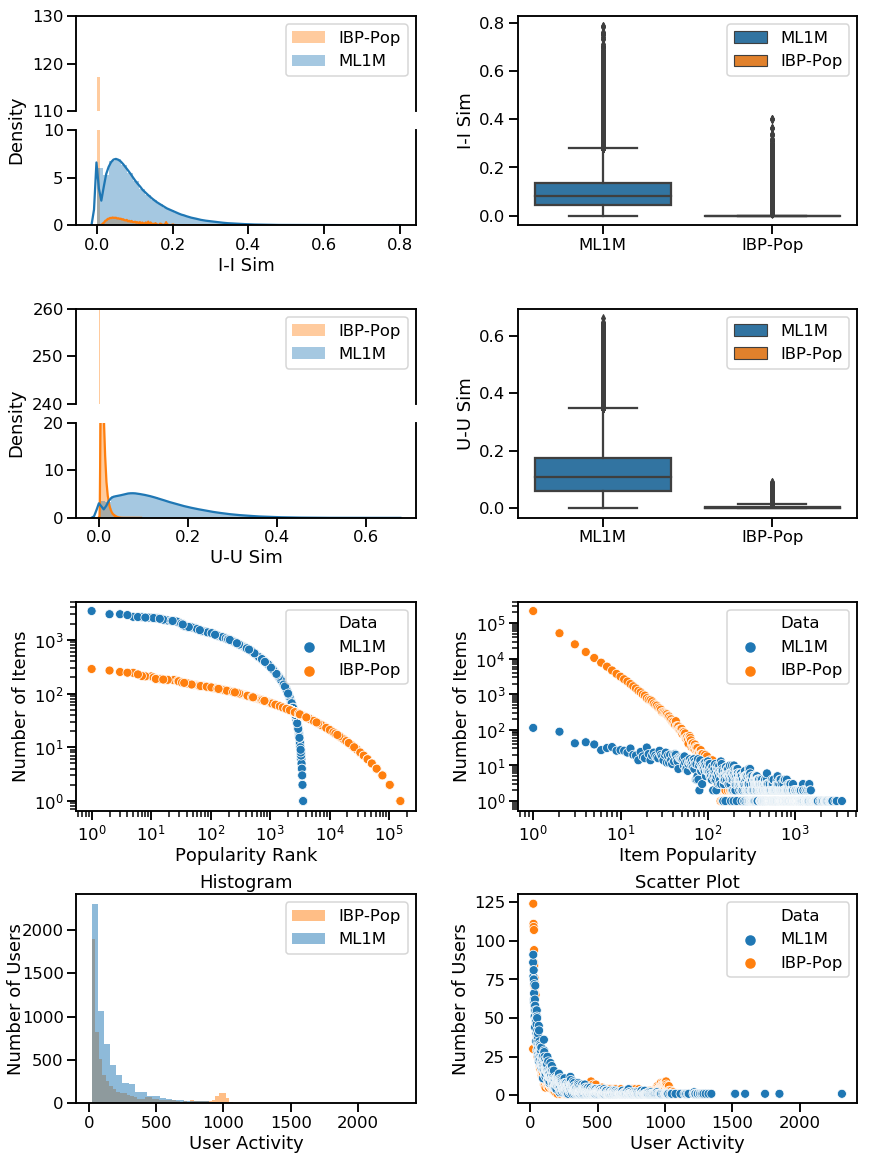

In [25]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-ml_1m-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop_csr-ml_1m-user-act.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Pop', simulated_data),
               ylim_left=((110, 130), (0, 10)), ylim_left2=((240, 260), (0, 20)), mrated=5)

### ibp pop on relative loss

In [45]:
search_space('build/skopt_ibp_pop-ml_1m.pkl')

('alpha', (20.519036683717676, 1000.0)) ('c', (0.01, 55.34632440058304)) ('sigma', (0.0, 0.99)) ('m', (16.0, 24.0)) ('alpha', (0.1, 19.9976029367816)) ('upper', (1851.2, 2764.204509434532)) 24.48046635405455


[1000.0, 0.01, 0.2559825185239383, 16.0, 0.1, 1851.2] 24.48046635405455
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  IBP-Pop    6040    5882  1738369  0.048931
item popularity stats
              ML1M      IBP-Pop
count  3706.000000  5882.000000
mean    269.889099   295.540462
std     384.047838   608.154948
min       1.000000     1.000000
25%      33.000000     1.000000
50%     123.500000     8.000000
75%     350.000000   127.000000
max    3428.000000  2092.000000
user profile stats
              ML1M      IBP-Pop
count  6040.000000  6040.000000
mean    165.597517   287.809437
std     192.747029   328.191208
min      20.000000    16.000000
25%      44.000000    42.000000
50%      96.000000   129.000000
75%     208.000000   427.000000
max    2314.000000  1045.000000


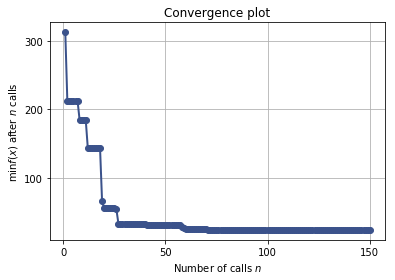

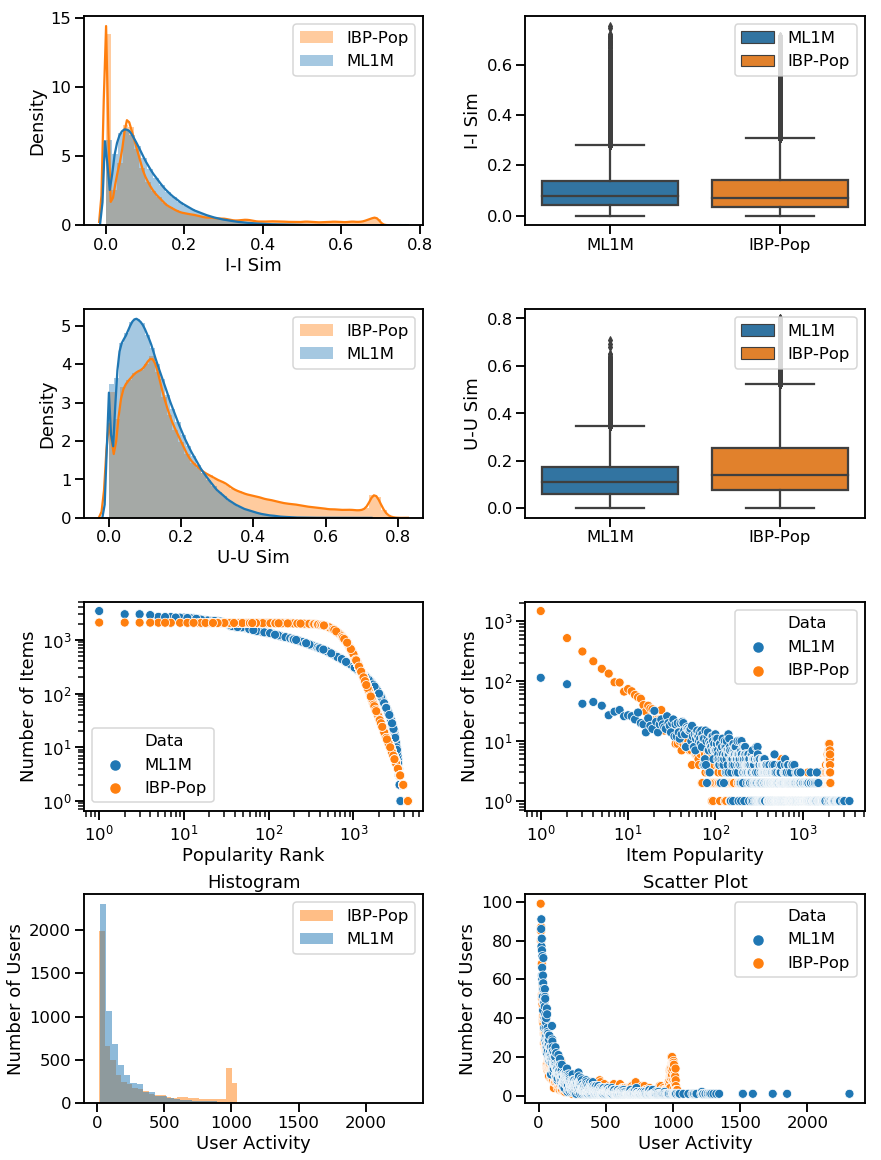

In [46]:
res_gp = skopt.load('build/skopt_ibp_pop-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop-ml_1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop-ml_1m.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Pop', simulated_data), mrated=5)

[1000.0, 0.01, 0.2559825185239383, 16.0, 0.1, 1851.2] 24.48046635405455
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0     ML1M    6040    3706  1000209  0.044684
1  IBP-Pop    6040    5882  1738369  0.048931
item popularity stats
              ML1M      IBP-Pop
count  3706.000000  5882.000000
mean    269.889099   295.540462
std     384.047838   608.154948
min       1.000000     1.000000
25%      33.000000     1.000000
50%     123.500000     8.000000
75%     350.000000   127.000000
max    3428.000000  2092.000000
user profile stats
              ML1M      IBP-Pop
count  6040.000000  6040.000000
mean    165.597517   287.809437
std     192.747029   328.191208
min      20.000000    16.000000
25%      44.000000    42.000000
50%      96.000000   129.000000
75%     208.000000   427.000000
max    2314.000000  1045.000000


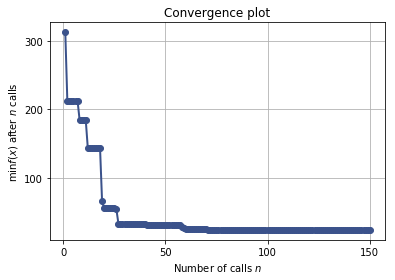

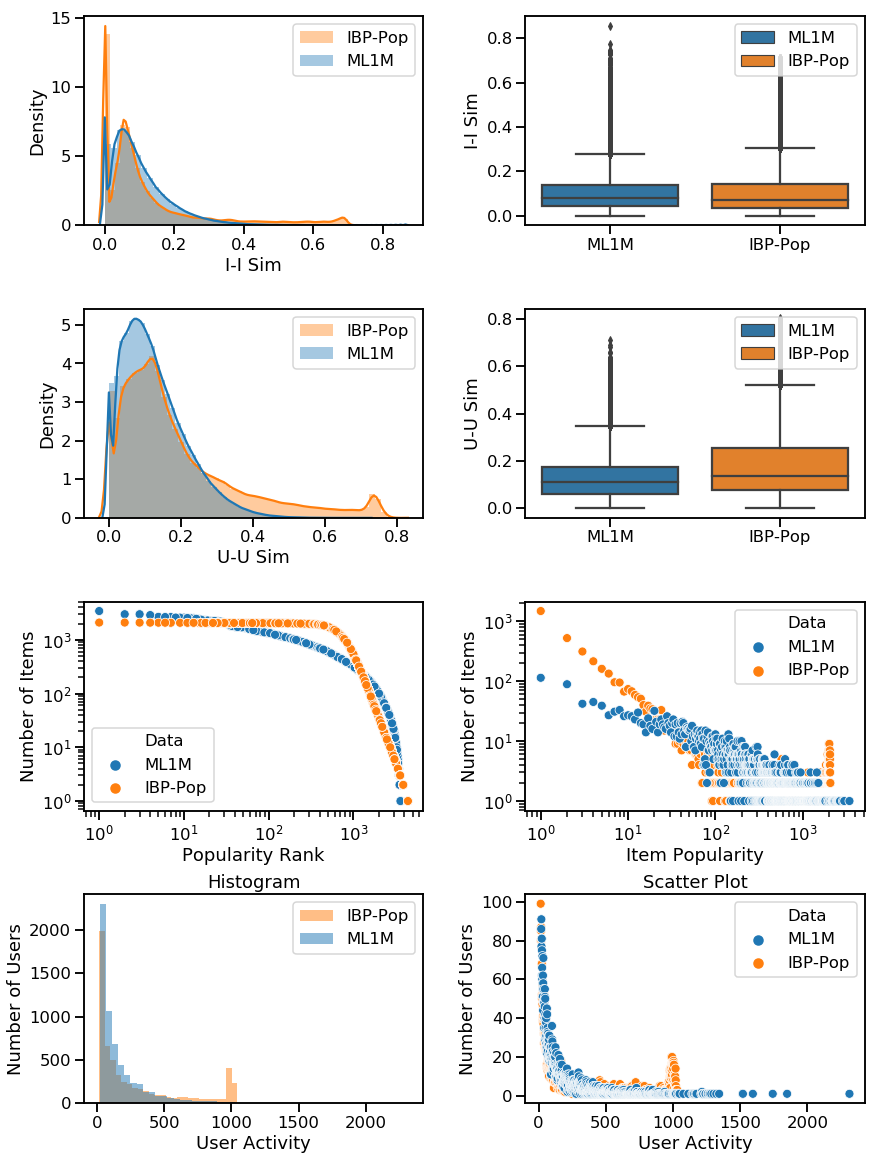

In [47]:
res_gp = skopt.load('build/skopt_ibp_pop-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop-ml_1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop-ml_1m.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('IBP-Pop', simulated_data), mrated=5)

### Unif unif on item item

[1550.7531034794251, 16.0, 1.2823774284924003, 2633.6061260391075] 1.6468318203567824
simulated data is used
dataset stats
     dataset  nusers  nitems   npairs   density
0       ML1M    6040    3706  1000209  0.044684
1  UNIF-Unif    6040    3706   313732  0.014016
item popularity stats
              ML1M    UNIF-Unif
count  3706.000000  3706.000000
mean    269.889099    84.655154
std     384.047838     8.998985
min       1.000000    54.000000
25%      33.000000    78.000000
50%     123.500000    85.000000
75%     350.000000    91.000000
max    3428.000000   121.000000
user profile stats
              ML1M    UNIF-Unif
count  6040.000000  6040.000000
mean    165.597517    51.942384
std     192.747029   102.131890
min      20.000000    16.000000
25%      44.000000    19.000000
50%      96.000000    27.000000
75%     208.000000    45.000000
max    2314.000000  1635.000000


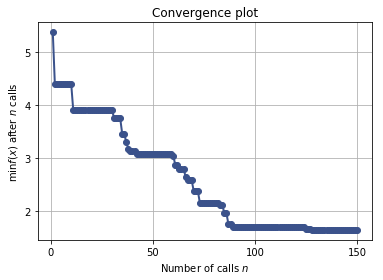

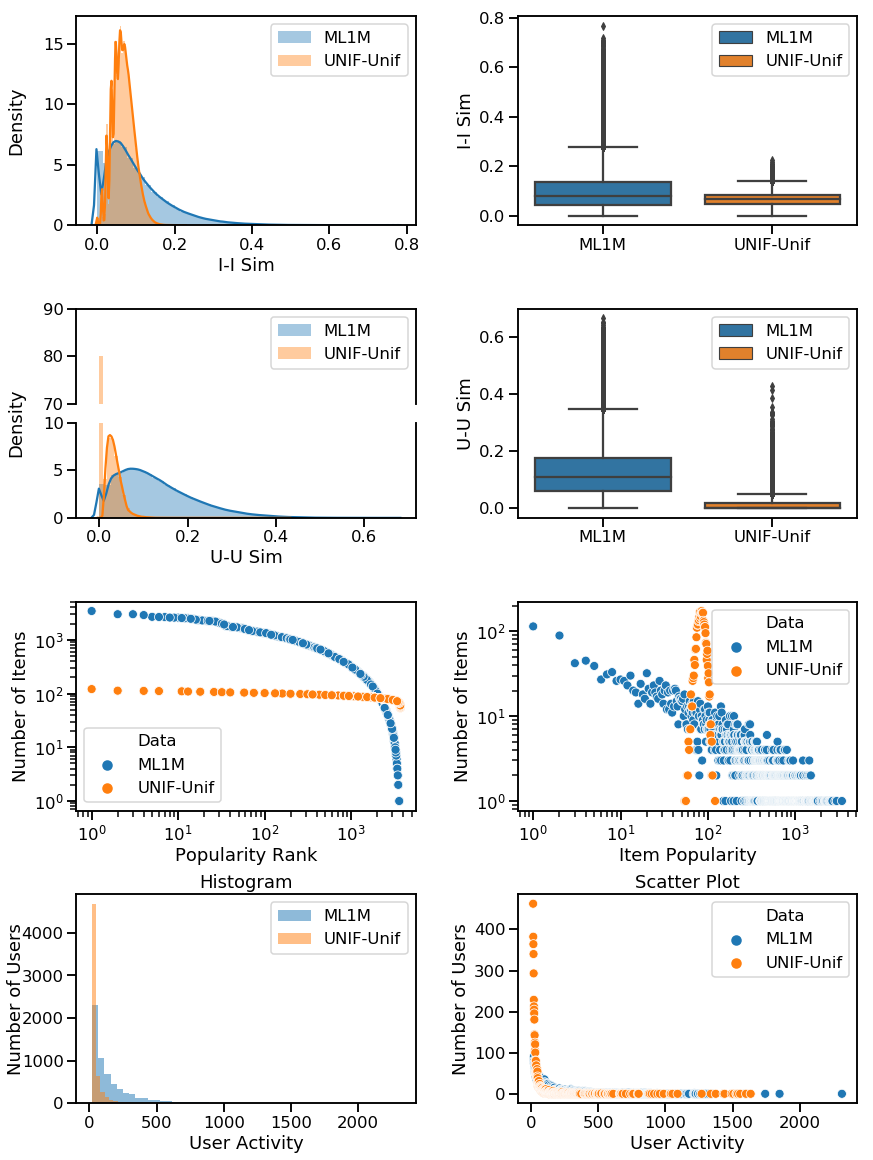

In [26]:
res_gp = skopt.load('build/gp_minimize_unif_unif_csr-ml_1m-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_unif_csr-ml_1m-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('UNIF-Unif', simulated_data), mrated=5,
               ylim_left2=((70, 90), (0, 10)))

### Unif unif on user user

[2000.0, 24.0, 0.1, 2776.7999999999997] 0.1894212706465473
simulated data is used
dataset stats
     dataset  nusers  nitems   npairs   density
0       ML1M    6040    3706  1000209  0.044684
1  UNIF-Unif    6040    3706  2846865  0.127182
item popularity stats
              ML1M    UNIF-Unif
count  3706.000000  3706.000000
mean    269.889099   768.177280
std     384.047838    22.645854
min       1.000000   669.000000
25%      33.000000   753.000000
50%     123.500000   768.000000
75%     350.000000   784.000000
max    3428.000000   866.000000
user profile stats
              ML1M    UNIF-Unif
count  6040.000000  6040.000000
mean    165.597517   471.335265
std     192.747029   580.777749
min      20.000000    24.000000
25%      44.000000    65.000000
50%      96.000000   192.000000
75%     208.000000   653.000000
max    2314.000000  2121.000000


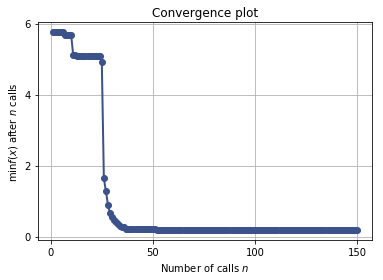

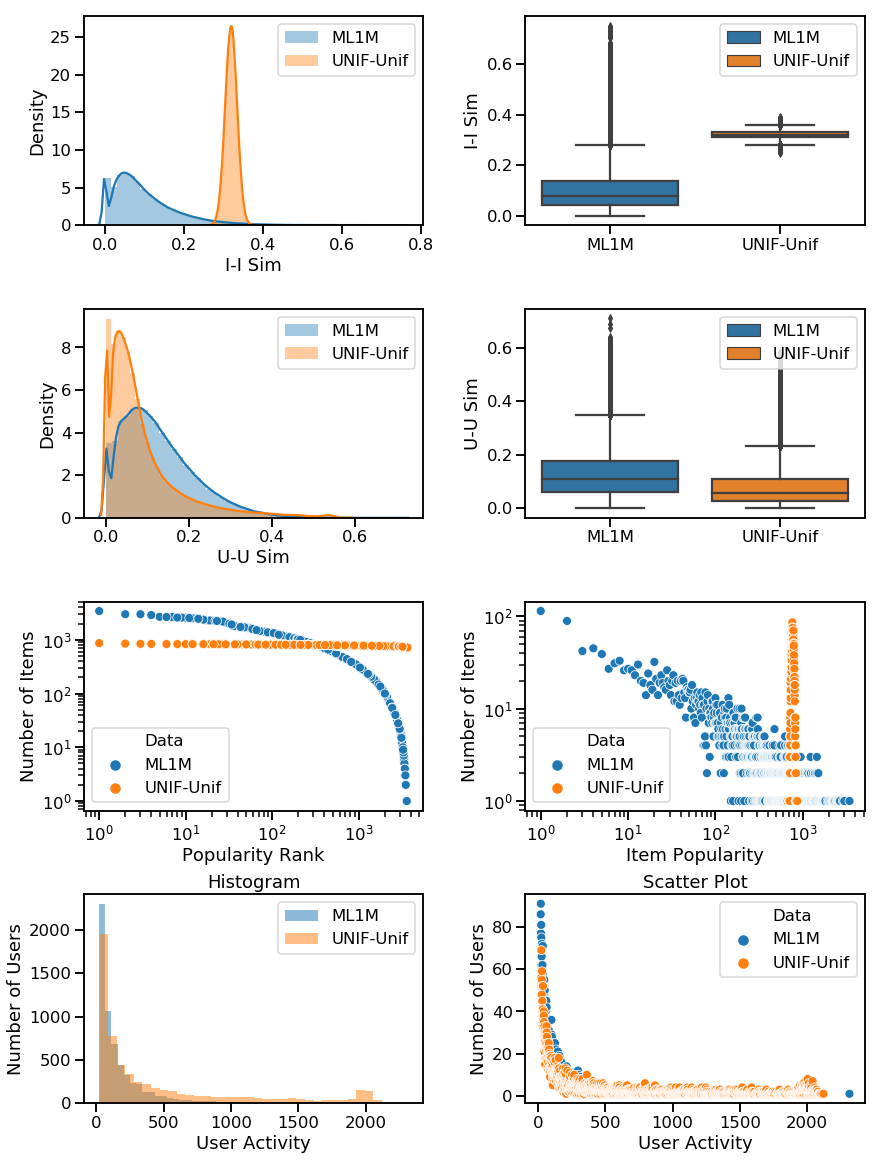

In [49]:
res_gp = skopt.load('build/gp_minimize_unif_unif_csr-ml_1m-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_unif_csr-ml_1m-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('UNIF-Unif', simulated_data), mrated=5)

### Unif unif on item pop

[5.000000000000001, 16.0, 15.777268851520216, 2776.7999999999997] 3.134526970789243
simulated data is used
dataset stats
     dataset  nusers  nitems   npairs   density
0       ML1M    6040    3706  1000209  0.044684
1  UNIF-Unif    6040    3703    30394  0.001359
item popularity stats
              ML1M    UNIF-Unif
count  3706.000000  3703.000000
mean    269.889099     8.207940
std     384.047838     2.879719
min       1.000000     1.000000
25%      33.000000     6.000000
50%     123.500000     8.000000
75%     350.000000    10.000000
max    3428.000000    21.000000
user profile stats
              ML1M    UNIF-Unif
count  6040.000000  6040.000000
mean    165.597517     5.032119
std     192.747029     2.224589
min      20.000000     1.000000
25%      44.000000     3.000000
50%      96.000000     5.000000
75%     208.000000     6.000000
max    2314.000000    15.000000


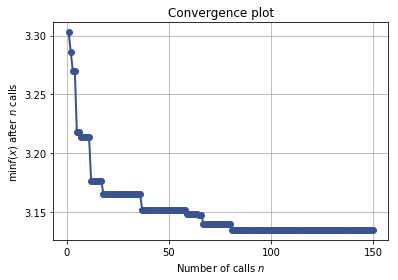

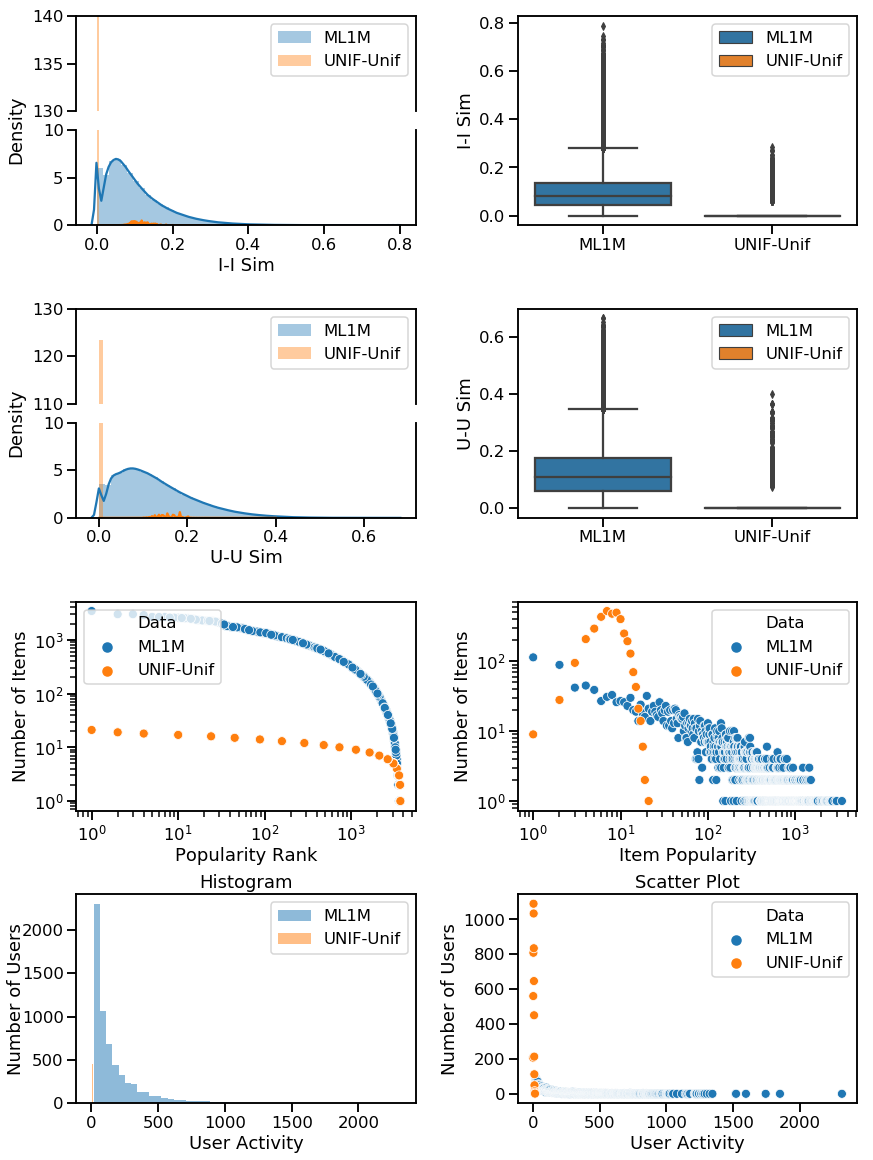

In [28]:
res_gp = skopt.load('build/gp_minimize_unif_unif_csr-ml_1m-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_unif_csr-ml_1m-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('UNIF-Unif', simulated_data),
               ylim_left=((130, 140), (0, 10)), ylim_left2=((110, 130), (0, 10)), mrated=5)

### Unif Unif on user act

[1779.2504419087998, 20.402897844274772, 0.3310415752787724, 1851.2] 0.24474026661079307
simulated data is used
dataset stats
     dataset  nusers  nitems   npairs   density
0       ML1M    6040    3706  1000209  0.044684
1  UNIF-Unif    6040    3706  1528596  0.068289
item popularity stats
              ML1M    UNIF-Unif
count  3706.000000  3706.000000
mean    269.889099   412.465192
std     384.047838    18.194006
min       1.000000   336.000000
25%      33.000000   400.000000
50%     123.500000   412.000000
75%     350.000000   425.000000
max    3428.000000   476.000000
user profile stats
              ML1M    UNIF-Unif
count  6040.000000  6040.000000
mean    165.597517   253.078808
std     192.747029   363.621142
min      20.000000    20.000000
25%      44.000000    39.000000
50%      96.000000    92.000000
75%     208.000000   291.000000
max    2314.000000  1842.000000


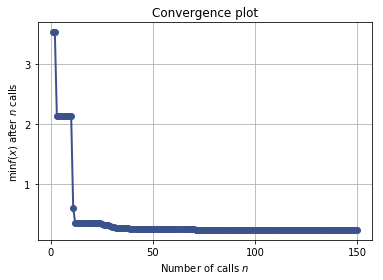

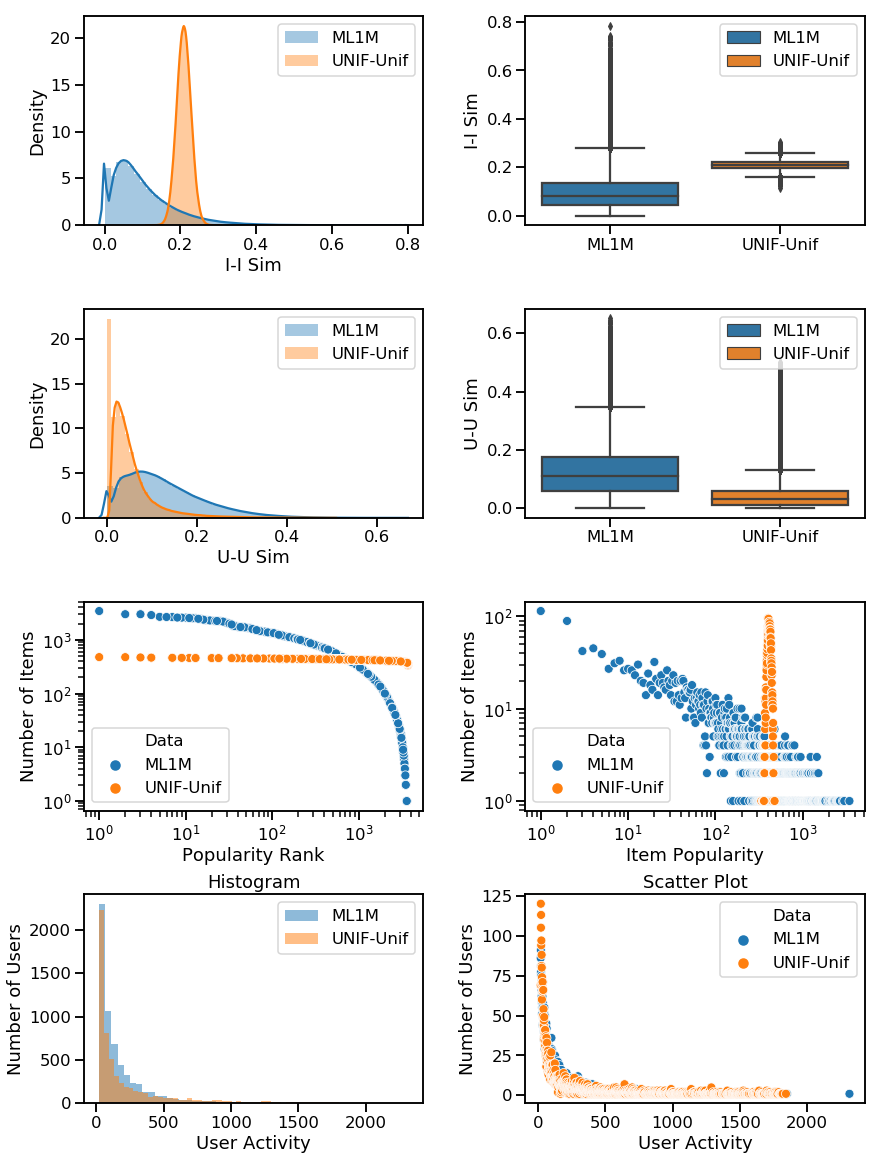

In [51]:
res_gp = skopt.load('build/gp_minimize_unif_unif_csr-ml_1m-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_unif_csr-ml_1m-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('UNIF-Unif', simulated_data), mrated=5)

### Unif Unif on relative loss

[298.88601266905715, 16.0, 0.1, 529.1117863311573] 465.82189224465196
simulated data is used
dataset stats
     dataset  nusers  nitems   npairs   density
0       ML1M    6040    3706  1000209  0.044684
1  UNIF-Unif    6040    3706   723415  0.032318
item popularity stats
              ML1M    UNIF-Unif
count  3706.000000  3706.000000
mean    269.889099   195.201025
std     384.047838    13.415334
min       1.000000   146.000000
25%      33.000000   186.000000
50%     123.500000   195.000000
75%     350.000000   204.000000
max    3428.000000   248.000000
user profile stats
              ML1M    UNIF-Unif
count  6040.000000  6040.000000
mean    165.597517   119.770695
std     192.747029   100.110652
min      20.000000    16.000000
25%      44.000000    34.000000
50%      96.000000    79.000000
75%     208.000000   196.000000
max    2314.000000   355.000000


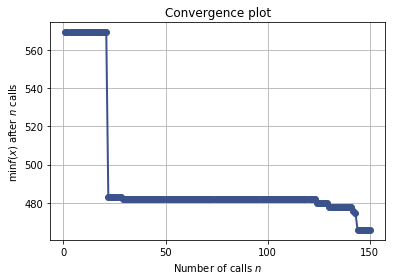

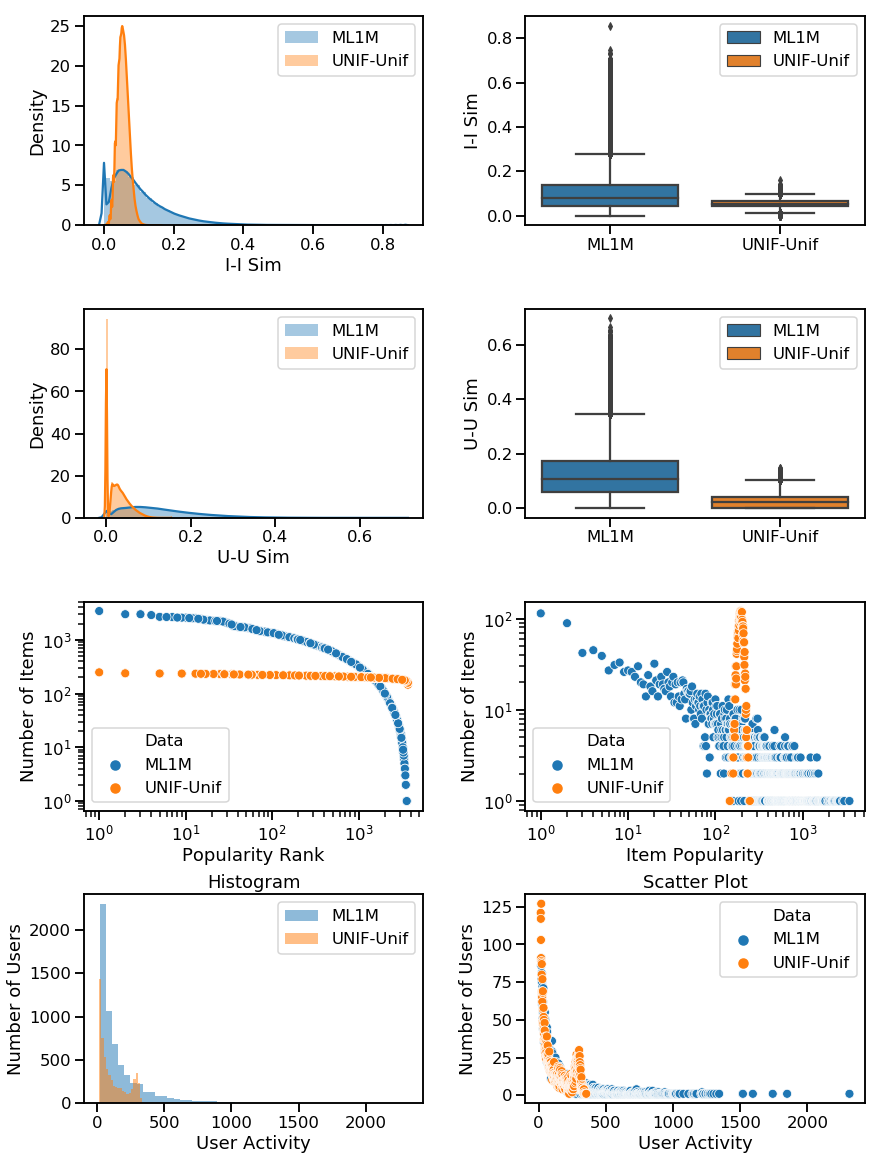

In [52]:
res_gp = skopt.load('build/skopt_unif_unif-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_unif-ml_1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('UNIF-Unif', simulated_data), mrated=5,
               ylim_left2=((60, 100), (0, 20)))

### Unif Pop on item item

[2000.0, 16.0, 1.3790437824015596, 2686.481627546122] 1.5841457594536685
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  UNIF-Pop    6040    3706   308376  0.013776
item popularity stats
              ML1M     UNIF-Pop
count  3706.000000  3706.000000
mean    269.889099    83.209930
std     384.047838     9.003953
min       1.000000    51.000000
25%      33.000000    77.000000
50%     123.500000    83.000000
75%     350.000000    89.000000
max    3428.000000   117.000000
user profile stats
              ML1M     UNIF-Pop
count  6040.000000  6040.000000
mean    165.597517    51.055629
std     192.747029   106.613873
min      20.000000    16.000000
25%      44.000000    19.000000
50%      96.000000    26.000000
75%     208.000000    43.000000
max    2314.000000  2040.000000


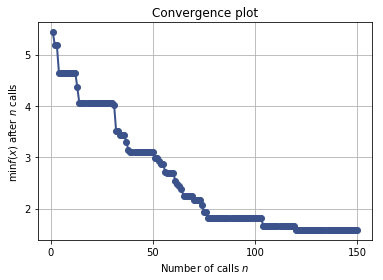

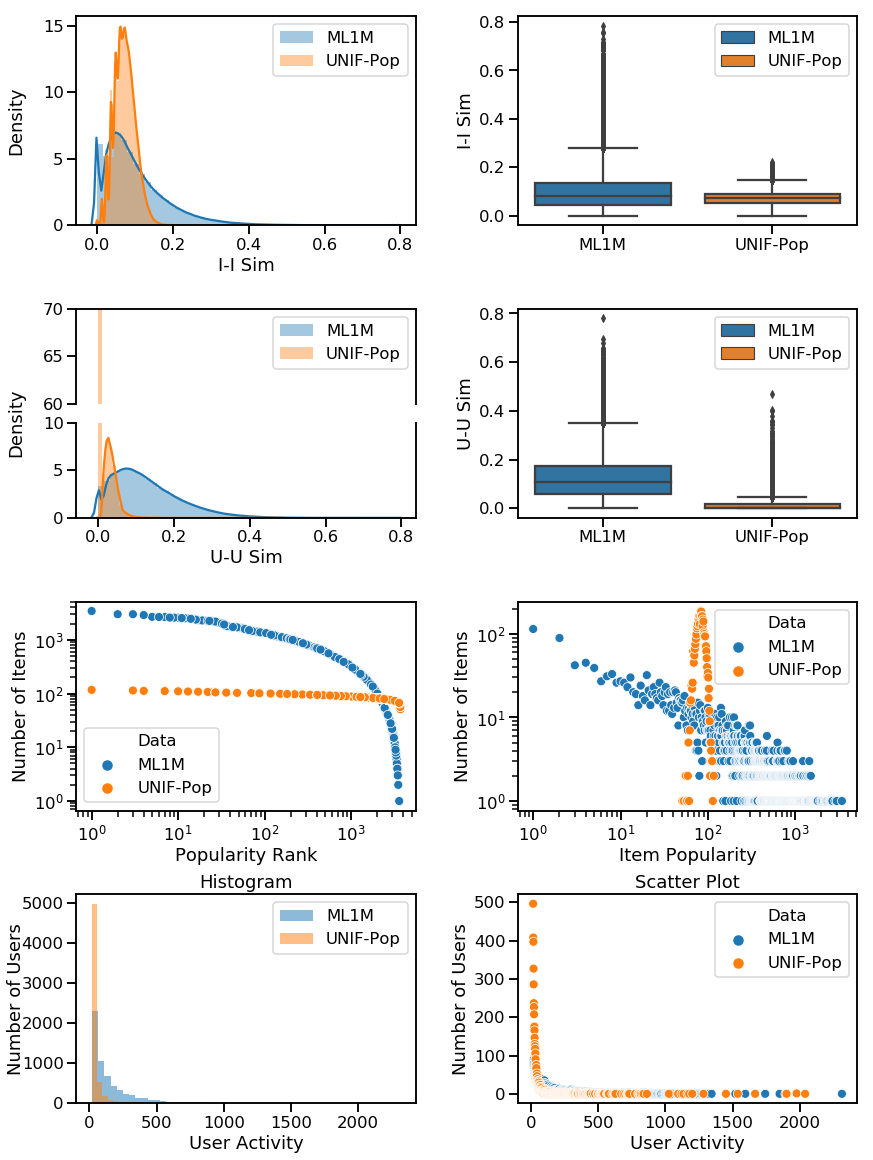

In [29]:
res_gp = skopt.load('build/gp_minimize_unif_pop_csr-ml_1m-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_pop_csr-ml_1m-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('UNIF-Pop', simulated_data), mrated=5, 
               ylim_left2=((60, 70), (0, 10)))

### Unif pop on user user

[1782.5790147483053, 24.0, 0.1, 2776.7999999999997] 0.19106765649376659
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  UNIF-Pop    6040    3706  2863956  0.127945
item popularity stats
              ML1M     UNIF-Pop
count  3706.000000  3706.000000
mean    269.889099   772.788991
std     384.047838    25.914585
min       1.000000   673.000000
25%      33.000000   756.000000
50%     123.500000   773.000000
75%     350.000000   790.000000
max    3428.000000   864.000000
user profile stats
              ML1M     UNIF-Pop
count  6040.000000  6040.000000
mean    165.597517   474.164901
std     192.747029   563.560771
min      20.000000    24.000000
25%      44.000000    66.000000
50%      96.000000   195.000000
75%     208.000000   695.250000
max    2314.000000  1903.000000


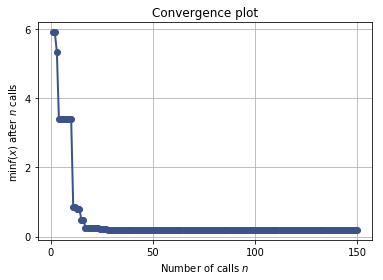

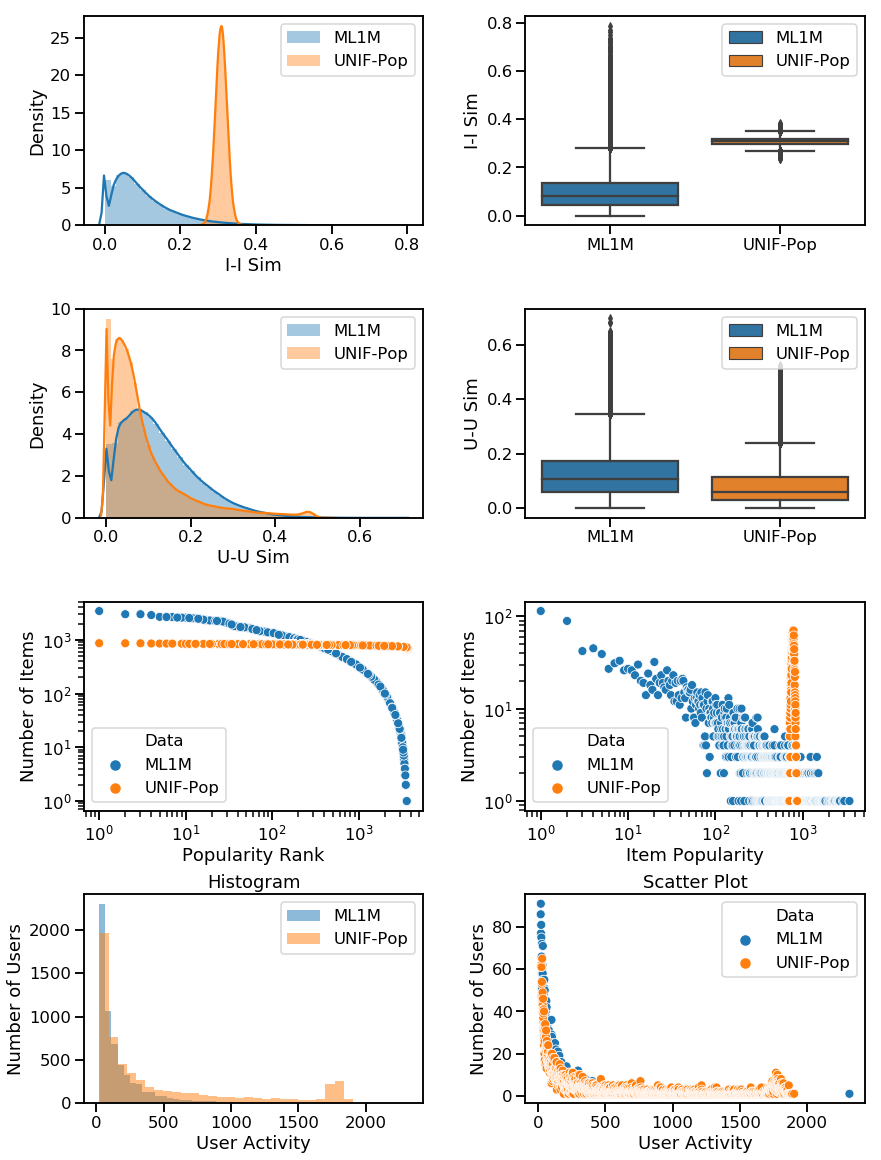

In [54]:
res_gp = skopt.load('build/gp_minimize_unif_pop_csr-ml_1m-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_pop_csr-ml_1m-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('UNIF-Pop', simulated_data), mrated=5)

### Unif Pop on item pop

[30.074770221556772, 16.0, 17.065189851802028, 1851.2] 2.9308806243579415
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  UNIF-Pop    6040    3706   100114  0.004473
item popularity stats
              ML1M     UNIF-Pop
count  3706.000000  3706.000000
mean    269.889099    27.014031
std     384.047838     6.973543
min       1.000000     5.000000
25%      33.000000    22.000000
50%     123.500000    27.000000
75%     350.000000    31.000000
max    3428.000000    55.000000
user profile stats
              ML1M     UNIF-Pop
count  6040.000000  6040.000000
mean    165.597517    16.575166
std     192.747029     1.024608
min      20.000000    13.000000
25%      44.000000    16.000000
50%      96.000000    16.000000
75%     208.000000    17.000000
max    2314.000000    26.000000


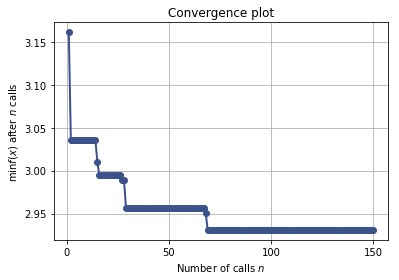

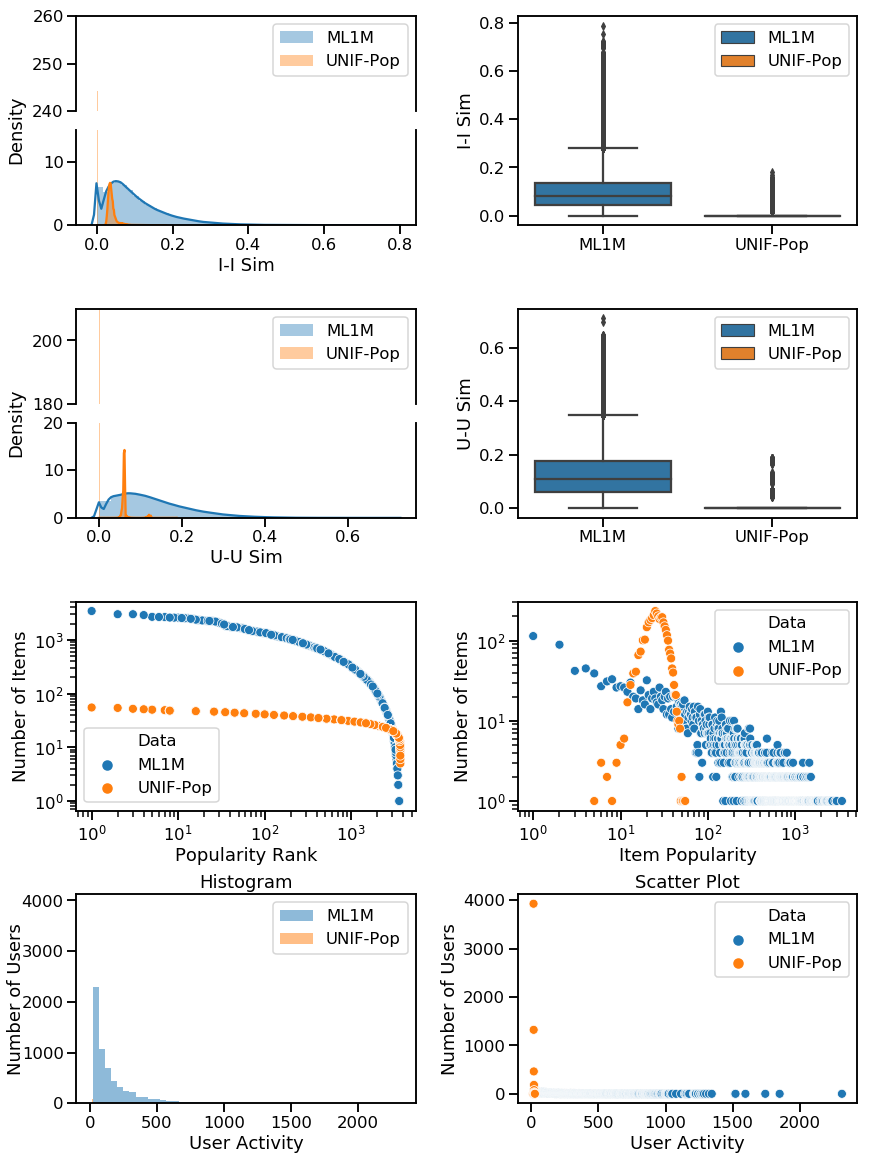

In [32]:
res_gp = skopt.load('build/gp_minimize_unif_pop_csr-ml_1m-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_pop_csr-ml_1m-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('UNIF-Pop', simulated_data),
               ylim_left=((240, 260), (0, 15)), ylim_left2=((180, 210), (0, 20)), mrated=5)

### Unif Pop on user act

[1586.7268461293531, 20.09556832690286, 0.319152683657532, 1851.2] 0.23795268664606162
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  UNIF-Pop    6040    3706  1545896  0.069062
item popularity stats
              ML1M     UNIF-Pop
count  3706.000000  3706.000000
mean    269.889099   417.133297
std     384.047838    20.089759
min       1.000000   346.000000
25%      33.000000   404.000000
50%     123.500000   417.000000
75%     350.000000   430.000000
max    3428.000000   493.000000
user profile stats
              ML1M     UNIF-Pop
count  6040.000000  6040.000000
mean    165.597517   255.943046
std     192.747029   363.416886
min      20.000000    20.000000
25%      44.000000    38.000000
50%      96.000000    89.000000
75%     208.000000   296.000000
max    2314.000000  1659.000000


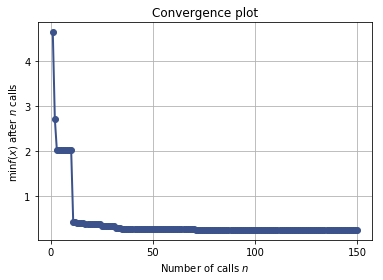

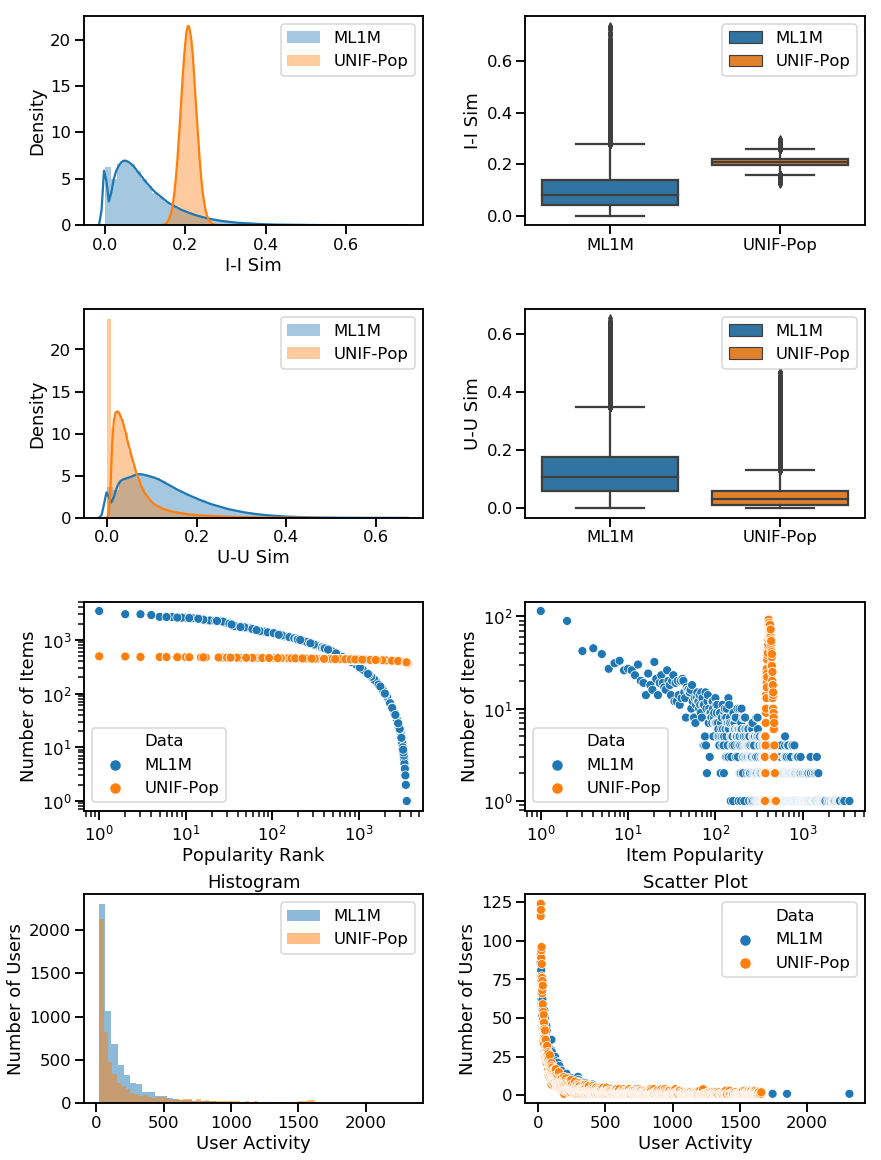

In [56]:
res_gp = skopt.load('build/gp_minimize_unif_pop_csr-ml_1m-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_pop_csr-ml_1m-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('UNIF-Pop', simulated_data), mrated=5)

### Unif Pop on relative loss

[2000.0, 16.521450743502506, 1.519279108235539, 2776.7999999999997] 262.06515583558394
simulated data is used


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


dataset stats
    dataset  nusers  nitems   npairs   density
0      ML1M    6040    3706  1000209  0.044684
1  UNIF-Pop    6040    3706   259164  0.011578
item popularity stats
              ML1M     UNIF-Pop
count  3706.000000  3706.000000
mean    269.889099    69.930923
std     384.047838     8.276828
min       1.000000    40.000000
25%      33.000000    64.000000
50%     123.500000    70.000000
75%     350.000000    75.000000
max    3428.000000   102.000000
user profile stats
              ML1M     UNIF-Pop
count  6040.000000  6040.000000
mean    165.597517    42.907947
std     192.747029    73.341334
min      20.000000    16.000000
25%      44.000000    19.000000
50%      96.000000    25.000000
75%     208.000000    41.000000
max    2314.000000  1983.000000


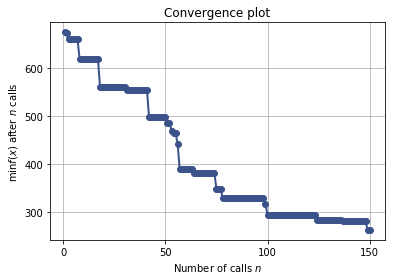

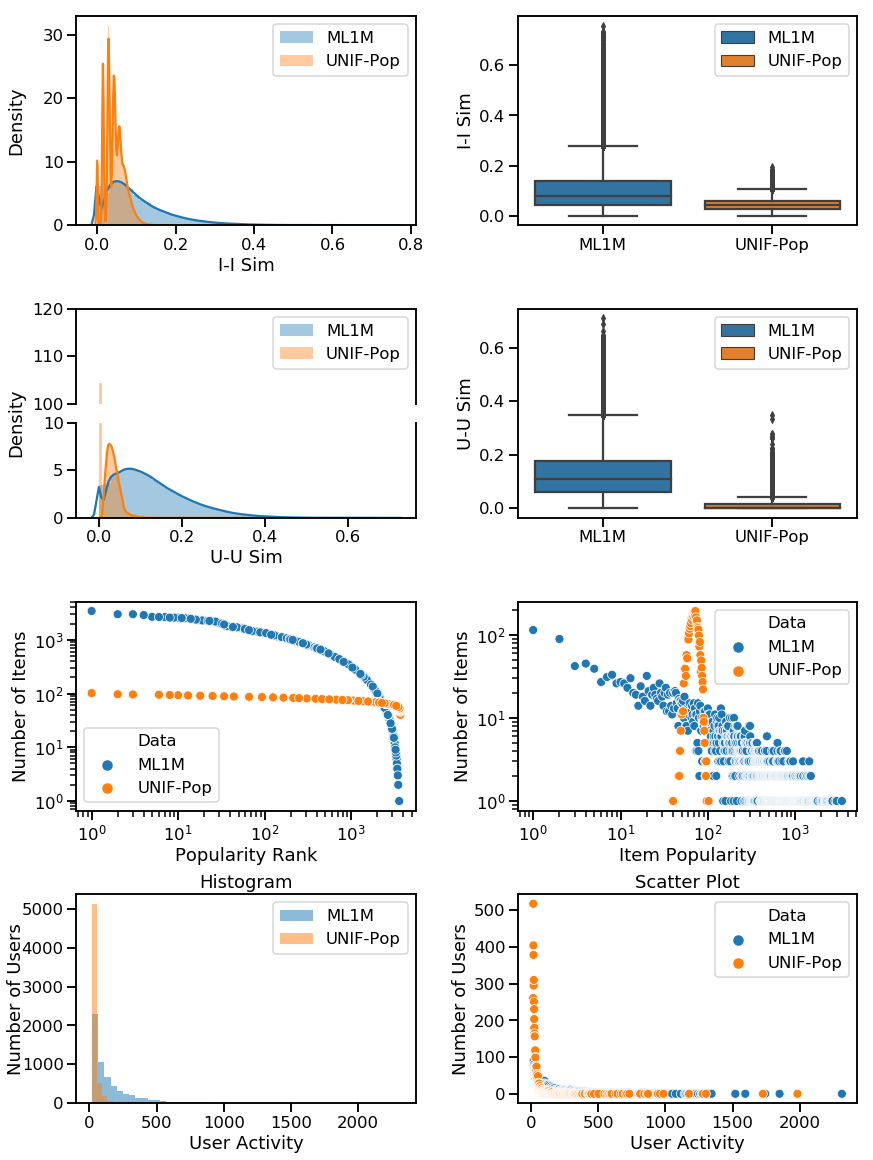

In [16]:
res_gp = skopt.load('build/skopt_unif_pop-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_pop-ml_1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('ML1M', ml_1m), ('UNIF-Pop', simulated_data),
               ylim_left2=((100, 120), (0, 10)), mrated=5)